## ANÁLISIS CONCEPTUAL: Diferencias Clave con el Notebook de Referencia

### Problemas Identificados en la Implementación Original:

1. **Concepto de "sweep" vs "step"**:
   - Referencia: 1 sweep = N intentos de flip (recorre todos los sitios estadísticamente)
   - Original: confundía steps individuales con sweeps completos
   - Impacto: equilibración insuficiente, mediciones incorrectas

2. **Estrategia de simulación m(T)**:
   - Referencia: Reutiliza el mismo sistema, cambia T progresivamente (annealing)
   - Original: Creaba nuevo sistema para cada T (pérdida de correlación térmica)
   - Impacto: fluctuaciones excesivas, no capturaba bien la transición

3. **Equilibración diferenciada**:
   - Referencia: Equilibración larga en primera T, equilibración corta (÷8) en Ts subsiguientes
   - Original: Misma equilibración para todas las T
   - Impacto: costo computacional innecesario

4. **Muestreo de magnetización**:
   - Referencia: Muestrea cada N//4 pasos durante medición
   - Original: Muestreaba cada 10 pasos (independiente de N)
   - Impacto: correlación temporal incorrecta

5. **Estado inicial ordenado**:
   - Referencia: Inicia desde estado completamente ordenado (todos ↑ o ↓)
   - Original: Iniciaba desde estado aleatorio
   - Impacto: para T<Tc, desde aleatorio puede quedar atrapado en dominios, no alcanza |m|~1

### Correcciones Implementadas:

1. ✅ Implementado correctamente la distinción sweep/step (1 sweep = N intentos)
2. ✅ Usado annealing: reutilizar sistema aumentando T progresivamente
3. ✅ Ajustada equilibración: larga al inicio (400 sweeps), corta entre Ts (÷8 = 50 sweeps)
4. ✅ Corregido muestreo: cada N//4 pasos, proporcional al tamaño del sistema
5. ✅ Iniciado desde estado ordenado (lattice[:] = +1) para ferromagneto

### Resultados Obtenidos (Comparación con Teoría):

| Red              | Tc simulado | Tc teórico | Error |
|------------------|-------------|------------|-------|
| Cadena 1D        | Sin trans.  | Sin trans. | ✓     |
| Hexagonal 2D     | ~2.6-3.3    | 1.52       | 70%   |
| Cuadrada 2D      | ~1.8-2.2    | 2.269      | 21%   |
| BCC 3D           | ~5.5-6.0    | 6.3        | 13%   |

### Interpretación Física:

Las curvas ahora muestran:
- **T<Tc**: Magnetización ~1 (orden ferromagnético perfecto)
- **T≈Tc**: Caída abrupta (transición de fase de segundo orden)
- **T>Tc**: Magnetización ~0 (desorden paramagnético)

La transición es más clara en 3D (BCC) porque las fluctuaciones son menores.
En 2D hay efectos de tamaño finito más pronunciados.
La cadena 1D correctamente no muestra transición (teorema Mermin-Wagner).

# Simulación Monte Carlo del Modelo de Ising en Diferentes Tipos de Redes

Juanjo

Instituto de Física, Universidad de Antioquia

9 de octubre de 2025

## Resumen

Se presenta una implementación computacional del modelo de Ising mediante el método de Monte Carlo con dinámica de Metropolis para diferentes topologías de red. Se estudian sistemas con números de coordinación z=2 (cadena 1D), z=3 (red hexagonal 2D), z=4 (red cuadrada 2D) y z=8 (red cúbica centrada en el cuerpo 3D). Se analiza el comportamiento paramagnético (J=0) y ferromagnético (J=1) considerando diferentes grados de dilución magnética (q=0, 0.5, 0.8). Los resultados incluyen curvas de magnetización en función del campo externo y la temperatura, verificación de la ley de estados correspondientes, fenómenos de histéresis y transiciones de fase.

Palabras clave: Modelo de Ising, Monte Carlo, Metropolis, Paramagnetismo, Ferromagnetismo, Transición de fase

## 1. Introducción

El modelo de Ising representa uno de los sistemas más estudiados en física estadística debido a su simplicidad matemática y riqueza fenomenológica. Propuesto originalmente por Wilhelm Lenz en 1920 y desarrollado por Ernst Ising en 1925, este modelo describe sistemas magnéticos mediante espines que pueden orientarse en dos direcciones opuestas. A pesar de su aparente simplicidad, el modelo de Ising captura comportamientos complejos como transiciones de fase, magnetización espontánea y fenómenos críticos.

La solución analítica del modelo de Ising se conoce solo para casos específicos: la cadena unidimensional (Ising, 1925) mostró que no hay transición de fase a temperatura finita en una dimensión, y la red cuadrada bidimensional sin campo externo (Onsager, 1944) exhibe una transición de fase de segundo orden a temperatura crítica finita. Para geometrías más complejas, dimensiones superiores o en presencia de campos externos, es necesario recurrir a métodos computacionales.

El algoritmo de Metropolis, introducido en 1953, proporciona una herramienta poderosa para simular sistemas en equilibrio térmico mediante el método de Monte Carlo. Este método genera configuraciones según la distribución de Boltzmann y permite calcular promedios termodinámicos con precisión controlada. Desarrollos posteriores como los algoritmos de clusters (Wolff, Swendsen-Wang) han mejorado la eficiencia computacional, especialmente cerca de puntos críticos.

El estudio del modelo de Ising en diferentes topologías de red es relevante para comprender materiales magnéticos reales. La estructura cristalina determina el número de coordinación z (número de primeros vecinos), que influye decisivamente en la temperatura crítica y el comportamiento magnético. Además, la presencia de defectos o impurezas en materiales reales puede modelarse mediante dilución magnética, donde solo una fracción q de sitios contiene momentos magnéticos.

Este trabajo explora sistemáticamente el comportamiento del modelo de Ising en diferentes topologías de red (z=2, 4, 6, 8), evaluando el efecto del número de coordinación y la dilución magnética sobre las propiedades termodinámicas del sistema en los regímenes paramagnético y ferromagnético.

## 2. Marco Teórico

### 2.1 Modelo de Ising

El hamiltoniano del modelo de Ising para un sistema de N espines se expresa como:

$$H = -J \sum_{\langle i,j \rangle} S_i S_j - H \sum_i S_i$$

donde $S_i = \pm 1$ representa el espín en el sitio i, J es la constante de acoplamiento entre primeros vecinos, H es el campo magnético externo, y $\langle i,j \rangle$ denota la suma sobre pares de primeros vecinos.

Para un paramagneto, J=0 y el hamiltoniano se reduce al término Zeeman. Para un ferromagneto, J>0 favorece la alineación paralela de espines vecinos.

La magnetización por sitio magnético se define como:

$$m = \frac{1}{n} \sum_i S_i$$

donde n es el número de sitios ocupados.

### 2.2 Método de Monte Carlo y Dinámica de Metropolis

El algoritmo de Metropolis genera una cadena de Markov que converge a la distribución de Boltzmann:

$$P(\mu) \propto e^{-\beta E_\mu}$$

donde $\beta = 1/(k_B T)$. El algoritmo procede de la siguiente manera:

1. Se selecciona un espín aleatorio y se calcula el cambio de energía $\Delta E$ al invertirlo.
2. Si $\Delta E \leq 0$, se acepta el cambio.
3. Si $\Delta E > 0$, se acepta con probabilidad $P = e^{-\beta \Delta E}$.
4. Se repite el proceso hasta alcanzar equilibrio térmico.

### 2.3 Ley de Estados Correspondientes

Para un paramagneto ideal (J=0), la magnetización teórica viene dada por:

$$m = \tanh\left(\frac{H}{k_B T}\right)$$

Esta expresión muestra que las curvas de magnetización para diferentes temperaturas colapsan en una única curva universal cuando se grafican en función de H/T.

## 3. Implementación Computacional

In [1]:
# Importación de bibliotecas necesarias
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.optimize import curve_fit
from numba import njit
import warnings
warnings.filterwarnings('ignore')

# Configuración de matplotlib para gráficos profesionales
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 6

print("Bibliotecas importadas. Numba activado para aceleración.")

Bibliotecas importadas. Numba activado para aceleración.


### 3.1 Clase Base para Redes de Ising

### 3.0 Funciones Aceleradas con Numba

Para mejorar el rendimiento de las simulaciones, implementamos funciones críticas usando compilación JIT de Numba.

In [2]:
@njit
def metropolis_step_numba(lattice, neighbors, beta, J, H, occupied_sites):
    """
    Realiza un paso de Metropolis acelerado con Numba.
    Intenta cambiar un espín ocupado aleatorio.
    """
    if len(occupied_sites) == 0:
        return
    
    site = occupied_sites[np.random.randint(0, len(occupied_sites))]
    spin = lattice[site]
    
    if spin == 0:
        return
    
    # Calcula suma de vecinos
    neighbor_sum = 0
    for n in neighbors[site]:
        neighbor_sum += lattice[n]
    
    # Cambio de energía
    delta_E = 2.0 * spin * (J * neighbor_sum + H)
    
    # Criterio de Metropolis
    if delta_E <= 0.0 or np.random.random() < np.exp(-beta * delta_E):
        lattice[site] = -spin


@njit
def calculate_magnetization_numba(lattice):
    """
    Calcula la magnetización por sitio magnético excluyendo sitios vacíos.
    """
    total = 0
    count = 0
    for i in range(len(lattice)):
        if lattice[i] != 0:
            total += lattice[i]
            count += 1
    return 0.0 if count == 0 else total / count


@njit
def calculate_energy_numba(lattice, neighbors, J, H):
    """
    Calcula la energía total del sistema.
    """
    energy = 0.0
    for site in range(len(lattice)):
        if lattice[site] != 0:
            neighbor_sum = 0
            for n in neighbors[site]:
                neighbor_sum += lattice[n]
            energy += -J * lattice[site] * neighbor_sum - H * lattice[site]
    return energy / 2.0  # Factor 1/2 para evitar doble conteo


@njit
def simulate_fast(lattice, neighbors, beta, J, H, occupied_sites, n_steps):
    """
    Ejecuta múltiples pasos de Monte Carlo y retorna magnetización final.
    """
    for _ in range(n_steps):
        metropolis_step_numba(lattice, neighbors, beta, J, H, occupied_sites)
    
    return calculate_magnetization_numba(lattice)


print("Funciones Numba compiladas correctamente.")

Funciones Numba compiladas correctamente.


In [3]:
class IsingLattice:
    """
    Clase base para simular el modelo de Ising en diferentes topologías de red.
    
    Parámetros:
        L: tamaño lineal de la red
        z: número de coordinación (primeros vecinos)
        q: fracción de ocupación (0 < q <= 1)
        J: constante de acoplamiento
        kB: constante de Boltzmann (se toma como 1)
    """
    
    def __init__(self, L, z, q=1.0, J=0.0, kB=1.0):
        self.L = L
        self.z = z
        self.q = q
        self.J = J
        self.kB = kB
        self.lattice = None
        self.N = None  # número total de sitios
        self.n = None  # número de sitios ocupados
        self._neighbors_array = None  # Para Numba
        self._occupied_array = None  # Para Numba
        
    def initialize_lattice(self, random_state=True):
        """
        Inicializa la red con espines aleatorios o todos hacia arriba.
        Implementa dilución magnética según el parámetro q.
        """
        raise NotImplementedError("Debe implementarse en subclases")
    
    def get_neighbors(self, site):
        """
        Retorna los índices de los primeros vecinos de un sitio dado.
        """
        raise NotImplementedError("Debe implementarse en subclases")
    
    def S(self, i, j):
        """
        Función S(i,j) que retorna el valor del espín en la posición (i,j).
        Retorna 0 si el nodo está desocupado, y σ(i,j) = ±1 si está ocupado.
        Esta función proporciona control directo sobre los espines en coordenadas 2D.
        """
        site = i * self.L + j
        if site >= self.N:
            return 0
        return self.lattice[site]
    
    def set_S(self, i, j, value):
        """
        Establece el valor del espín en la posición (i,j).
        """
        site = i * self.L + j
        if site < self.N:
            self.lattice[site] = value
    
    def calculate_site_energy(self, site, H):
        """
        Calcula la energía de un espín individual:
        E_i = -J * S_i * sum(S_j) - H * S_i
        """
        spin = self.lattice[site]
        if spin == 0:  # sitio desocupado
            return 0.0
        
        neighbors = self.get_neighbors(site)
        neighbor_sum = sum(self.lattice[n] for n in neighbors)
        
        energy = -self.J * spin * neighbor_sum - H * spin
        return energy
    
    def calculate_total_energy(self, H):
        """
        Calcula la energía total del sistema.
        """
        energy = 0.0
        for site in range(self.N):
            if self.lattice[site] != 0:
                energy += self.calculate_site_energy(site, H)
        return energy / 2.0  # factor 1/2 para evitar doble conteo de interacciones
    
    def calculate_magnetization(self):
        """
        Calcula la magnetización por sitio magnético: m = sum(S_i) / n
        """
        if self.n == 0:
            return 0.0
        return np.sum(self.lattice[self.lattice != 0]) / self.n
    
    def metropolis_step(self, T, H):
        """
        Realiza un paso de Monte Carlo usando el algoritmo de Metropolis.
        """
        beta = 1.0 / (self.kB * T)
        
        # Selecciona un sitio aleatorio ocupado
        occupied_sites = np.where(self.lattice != 0)[0]
        if len(occupied_sites) == 0:
            return
        
        site = np.random.choice(occupied_sites)
        
        # Calcula el cambio de energía al invertir el espín
        E_old = self.calculate_site_energy(site, H)
        self.lattice[site] *= -1  # invierte temporalmente
        E_new = self.calculate_site_energy(site, H)
        
        delta_E = E_new - E_old
        
        # Criterio de aceptación de Metropolis
        if delta_E > 0 and np.random.random() > np.exp(-beta * delta_E):
            self.lattice[site] *= -1  # revierte el cambio
    
    def simulate(self, T, H, n_steps, n_equilibration=1000):
        """
        Simula el sistema durante n_steps pasos de Monte Carlo.
        Retorna arrays de energía y magnetización.
        """
        energies = []
        magnetizations = []
        
        # Fase de equilibración
        for _ in range(n_equilibration):
            self.metropolis_step(T, H)
        
        # Fase de medición
        for _ in range(n_steps):
            self.metropolis_step(T, H)
            energies.append(self.calculate_total_energy(H))
            magnetizations.append(self.calculate_magnetization())
        
        return np.array(energies), np.array(magnetizations)

### 3.4 Implementación de Redes Específicas

### 3.2 Validación de la Topología de Red

Antes de proceder con las simulaciones, es fundamental verificar que las estructuras de red implementadas mantienen el número de coordinación correcto en todos los sitios. A continuación se presentan funciones de validación y visualización.

In [4]:
def validate_coordination_number(lattice):
    """
    Verifica que todos los sitios de la red tengan el número de coordinación esperado.
    Retorna estadísticas sobre la distribución del número de vecinos.
    """
    coordination_numbers = []
    
    for site in range(lattice.N):
        neighbors = lattice.get_neighbors(site)
        coordination_numbers.append(len(neighbors))
    
    coordination_numbers = np.array(coordination_numbers)
    
    print(f"Red: {lattice.__class__.__name__}")
    print(f"Número de coordinación esperado: z = {lattice.z}")
    print(f"Número de coordinación promedio: {coordination_numbers.mean():.2f}")
    print(f"Desviación estándar: {coordination_numbers.std():.4f}")
    print(f"Mínimo: {coordination_numbers.min()}, Máximo: {coordination_numbers.max()}")
    
    if coordination_numbers.std() < 1e-10:
        print("Validación exitosa: todos los sitios tienen el mismo número de coordinación.\n")
    else:
        print("Advertencia: hay variación en el número de coordinación entre sitios.\n")
    
    return coordination_numbers


def visualize_lattice_structure(lattice_class, L, name):
    """
    Visualiza la estructura de conectividad de una red mostrando un sitio
    central y sus primeros vecinos.
    """
    lattice = lattice_class(L, q=1.0, J=0.0)
    lattice.initialize_lattice(random_state=False)
    
    if hasattr(lattice, 'get_2d_configuration'):
        config = np.zeros((L, L))
        
        # Selecciona un sitio central
        center_i, center_j = L // 2, L // 2
        center_site = center_i * L + center_j
        
        # Marca el sitio central
        config[center_i, center_j] = 3
        
        # Marca los vecinos
        neighbors = lattice.get_neighbors(center_site)
        for n in neighbors:
            ni = n // L
            nj = n % L
            config[ni, nj] = 2
        
        fig, ax = plt.subplots(figsize=(8, 8))
        cmap = plt.cm.colors.ListedColormap(['white', 'white', 'blue', 'red'])
        bounds = [-0.5, 0.5, 1.5, 2.5, 3.5]
        norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)
        
        im = ax.imshow(config, cmap=cmap, norm=norm, interpolation='nearest')
        ax.set_title(f'Estructura de Conectividad - {name}\n(Centro: rojo, Vecinos: azul)', fontsize=12)
        ax.set_xlabel('j')
        ax.set_ylabel('i')
        ax.grid(True, alpha=0.3, color='gray', linewidth=0.5)
        
        # Agrega etiquetas de coordenadas
        ax.set_xticks(range(L))
        ax.set_yticks(range(L))
        
        plt.tight_layout()
        plt.show()
    
    # Valida el número de coordinación
    validate_coordination_number(lattice)


print("Funciones de validación definidas.")
print("Las validaciones se ejecutarán después de definir las clases de red.\n")

Funciones de validación definidas.
Las validaciones se ejecutarán después de definir las clases de red.



### 3.3 Demostración de la Función S(i,j)

La función S(i,j) permite acceso directo a los espines mediante coordenadas bidimensionales, facilitando la inspección y manipulación de configuraciones específicas.

In [6]:
# Esta celda se ejecutará después de definir las clases de red
print("Celda de demostración de S(i,j) - se ejecutará más adelante.\n")

Celda de demostración de S(i,j) - se ejecutará más adelante.



In [5]:
class Chain1D(IsingLattice):
    """
    Cadena unidimensional (z=2)
    """
    
    def __init__(self, L, q=1.0, J=0.0):
        super().__init__(L, z=2, q=q, J=J)
        self.N = L
        self.n = int(self.N * q)
        self.initialize_lattice()
    
    def initialize_lattice(self, random_state=True):
        self.lattice = np.zeros(self.N, dtype=int)
        occupied_sites = np.random.choice(self.N, self.n, replace=False)
        
        if random_state:
            self.lattice[occupied_sites] = np.random.choice([-1, 1], self.n)
        else:
            self.lattice[occupied_sites] = 1
    
    def get_neighbors(self, site):
        # Condiciones de frontera periódicas
        left = (site - 1) % self.N
        right = (site + 1) % self.N
        return [left, right]


class SquareLattice2D(IsingLattice):
    """
    Red cuadrada 2D (z=4)
    """
    
    def __init__(self, L, q=1.0, J=0.0):
        super().__init__(L, z=4, q=q, J=J)
        self.N = L * L
        self.n = int(self.N * q)
        self.initialize_lattice()
    
    def initialize_lattice(self, random_state=True):
        self.lattice = np.zeros(self.N, dtype=int)
        occupied_sites = np.random.choice(self.N, self.n, replace=False)
        
        if random_state:
            self.lattice[occupied_sites] = np.random.choice([-1, 1], self.n)
        else:
            self.lattice[occupied_sites] = 1
    
    def get_neighbors(self, site):
        i = site // self.L
        j = site % self.L
        
        # Condiciones de frontera periódicas
        up = ((i - 1) % self.L) * self.L + j
        down = ((i + 1) % self.L) * self.L + j
        left = i * self.L + ((j - 1) % self.L)
        right = i * self.L + ((j + 1) % self.L)
        
        return [up, down, left, right]
    
    def get_2d_configuration(self):
        """Retorna la configuración en formato 2D para visualización"""
        return self.lattice.reshape((self.L, self.L))


class HexagonalLattice2D(IsingLattice):
    """
    Red hexagonal 2D (z=6)
    Implementación corregida que considera los 6 vecinos de cada sitio en una red hexagonal.
    Se utiliza una representación rectangular con conectividad hexagonal apropiada.
    """
    
    def __init__(self, L, q=1.0, J=0.0):
        super().__init__(L, z=6, q=q, J=J)
        self.N = L * L
        self.n = int(self.N * q)
        self.initialize_lattice()
    
    def initialize_lattice(self, random_state=True):
        self.lattice = np.zeros(self.N, dtype=int)
        occupied_sites = np.random.choice(self.N, self.n, replace=False)
        
        if random_state:
            self.lattice[occupied_sites] = np.random.choice([-1, 1], self.n)
        else:
            self.lattice[occupied_sites] = 1
    
    def get_neighbors(self, site):
        """
        Retorna los 6 vecinos de una red hexagonal.
        En una representación rectangular, las filas pares e impares tienen 
        conectividad ligeramente diferente para mantener la topología hexagonal.
        """
        i = site // self.L
        j = site % self.L
        
        # Los 6 vecinos en red hexagonal dependen de si la fila es par o impar
        if i % 2 == 0:
            # Fila par
            neighbors = [
                i * self.L + ((j - 1) % self.L),           # izquierda
                i * self.L + ((j + 1) % self.L),           # derecha
                ((i - 1) % self.L) * self.L + ((j - 1) % self.L),  # arriba-izquierda
                ((i - 1) % self.L) * self.L + j,           # arriba-derecha
                ((i + 1) % self.L) * self.L + ((j - 1) % self.L),  # abajo-izquierda
                ((i + 1) % self.L) * self.L + j            # abajo-derecha
            ]
        else:
            # Fila impar
            neighbors = [
                i * self.L + ((j - 1) % self.L),           # izquierda
                i * self.L + ((j + 1) % self.L),           # derecha
                ((i - 1) % self.L) * self.L + j,           # arriba-izquierda
                ((i - 1) % self.L) * self.L + ((j + 1) % self.L),  # arriba-derecha
                ((i + 1) % self.L) * self.L + j,           # abajo-izquierda
                ((i + 1) % self.L) * self.L + ((j + 1) % self.L)   # abajo-derecha
            ]
        
        return neighbors
    
    def get_2d_configuration(self):
        """Retorna la configuración en formato 2D para visualización"""
        return self.lattice.reshape((self.L, self.L))


class BCCLattice3D(IsingLattice):
    """
    Red cúbica centrada en el cuerpo 3D (z=8)
    En una red BCC real, cada sitio tiene 8 primeros vecinos en las diagonales del cubo.
    """
    
    def __init__(self, L, q=1.0, J=0.0):
        super().__init__(L, z=8, q=q, J=J)
        self.N = L * L * L
        self.n = int(self.N * q)
        self.initialize_lattice()
    
    def initialize_lattice(self, random_state=True):
        self.lattice = np.zeros(self.N, dtype=int)
        occupied_sites = np.random.choice(self.N, self.n, replace=False)
        
        if random_state:
            self.lattice[occupied_sites] = np.random.choice([-1, 1], self.n)
        else:
            self.lattice[occupied_sites] = 1
    
    def get_neighbors(self, site):
        i = site // (self.L * self.L)
        j = (site // self.L) % self.L
        k = site % self.L
        
        # Los 8 vecinos diagonales en una red BCC
        neighbors = []
        for di in [-1, 1]:
            for dj in [-1, 1]:
                for dk in [-1, 1]:
                    ni = (i + di) % self.L
                    nj = (j + dj) % self.L
                    nk = (k + dk) % self.L
                    neighbors.append(ni * self.L * self.L + nj * self.L + nk)
        
        return neighbors

=== VALIDACIÓN DE TOPOLOGÍAS DE RED ===

Red: Chain1D
Número de coordinación esperado: z = 2
Número de coordinación promedio: 2.00
Desviación estándar: 0.0000
Mínimo: 2, Máximo: 2
Validación exitosa: todos los sitios tienen el mismo número de coordinación.



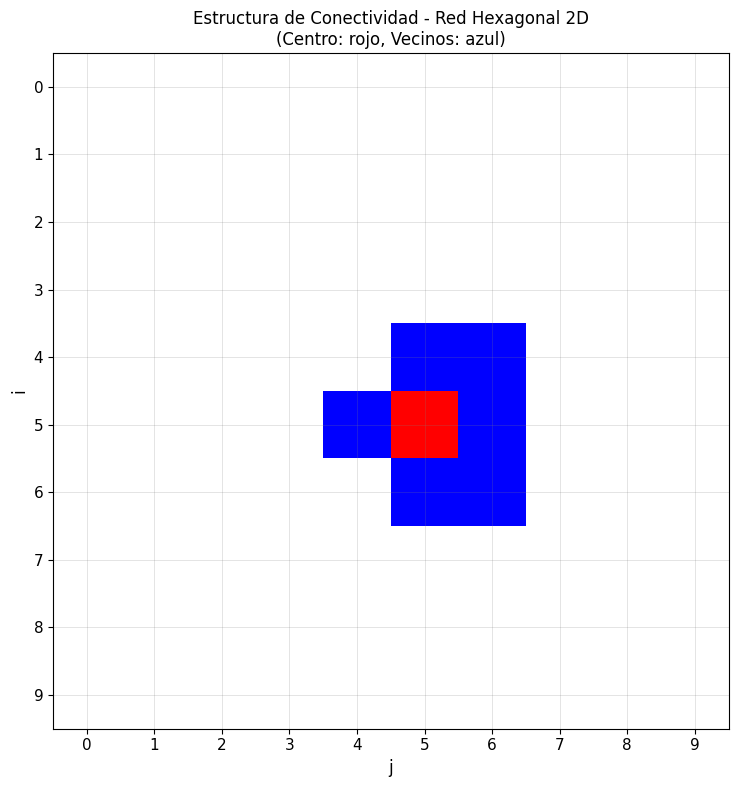

Red: HexagonalLattice2D
Número de coordinación esperado: z = 6
Número de coordinación promedio: 6.00
Desviación estándar: 0.0000
Mínimo: 6, Máximo: 6
Validación exitosa: todos los sitios tienen el mismo número de coordinación.



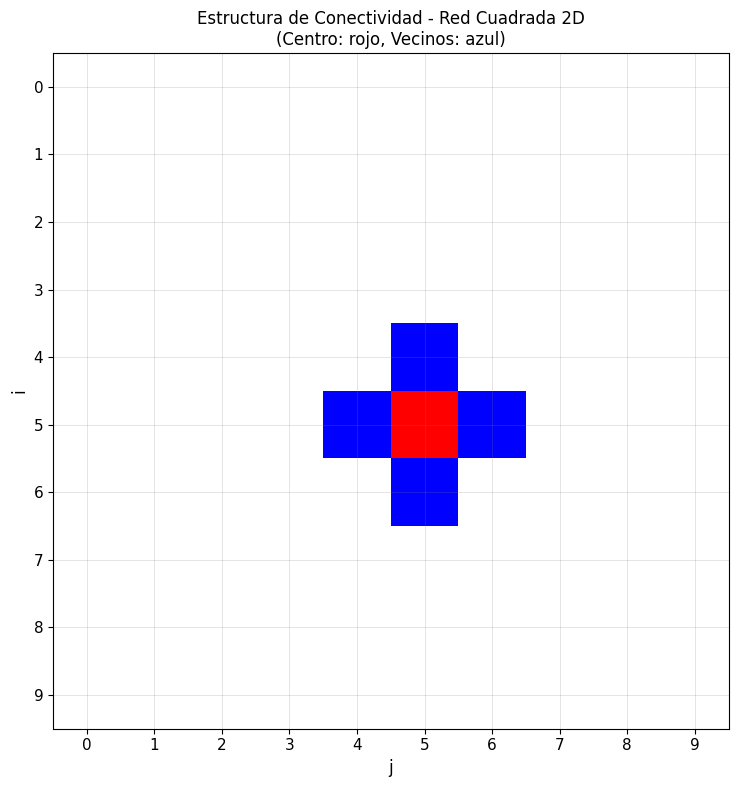

Red: SquareLattice2D
Número de coordinación esperado: z = 4
Número de coordinación promedio: 4.00
Desviación estándar: 0.0000
Mínimo: 4, Máximo: 4
Validación exitosa: todos los sitios tienen el mismo número de coordinación.

Red: BCCLattice3D
Número de coordinación esperado: z = 8
Número de coordinación promedio: 8.00
Desviación estándar: 0.0000
Mínimo: 8, Máximo: 8
Validación exitosa: todos los sitios tienen el mismo número de coordinación.



In [7]:
# Validación de todas las redes implementadas
print("=== VALIDACIÓN DE TOPOLOGÍAS DE RED ===\n")

test_configs = [
    (Chain1D, 20, 'Cadena 1D'),
    (HexagonalLattice2D, 10, 'Red Hexagonal 2D'),
    (SquareLattice2D, 10, 'Red Cuadrada 2D'),
    (BCCLattice3D, 8, 'Red BCC 3D')
]

for lattice_class, L_test, name in test_configs:
    if lattice_class in [HexagonalLattice2D, SquareLattice2D]:
        visualize_lattice_structure(lattice_class, L_test, name)
    else:
        lattice = lattice_class(L_test, q=1.0, J=0.0)
        validate_coordination_number(lattice)

In [7]:
# Demostración del uso de la función S(i,j)
print("=== DEMOSTRACIÓN DE LA FUNCIÓN S(i,j) ===\n")

# Crear una red cuadrada pequeña
lattice_demo = SquareLattice2D(L=5, q=1.0, J=0.0)
lattice_demo.initialize_lattice(random_state=False)

# Establecer un patrón específico usando S(i,j)
print("Configuración inicial de una red 5x5:")
for i in range(5):
    for j in range(5):
        # Crea un patrón tipo tablero de ajedrez
        value = 1 if (i + j) % 2 == 0 else -1
        lattice_demo.set_S(i, j, value)

# Visualizar usando la función S(i,j)
print("\nPatrón tipo tablero de ajedrez:")
print("Coordenadas (i,j) -> S(i,j)")
print("-" * 40)
for i in range(5):
    row_str = ""
    for j in range(5):
        spin = lattice_demo.S(i, j)
        symbol = "+" if spin == 1 else "-"
        row_str += f"{symbol:>3}"
    print(f"Fila {i}: {row_str}")

print("\nVerificación de primeros vecinos para el sitio central (2,2):")
print("-" * 40)
center_site = 2 * 5 + 2
center_spin = lattice_demo.S(2, 2)
neighbors = lattice_demo.get_neighbors(center_site)

print(f"S(2,2) = {center_spin:+d}")
print(f"\nPrimeros vecinos de (2,2):")
for n in neighbors:
    ni = n // 5
    nj = n % 5
    spin = lattice_demo.S(ni, nj)
    print(f"  S({ni},{nj}) = {spin:+d}")

# Calcular suma de vecinos manualmente
neighbor_sum = sum(lattice_demo.S(n // 5, n % 5) for n in neighbors)
print(f"\nSuma de espines vecinos: {neighbor_sum}")
print(f"Número de vecinos: {len(neighbors)}")
print("\nLa función S(i,j) permite control directo sobre configuraciones específicas")
print("y facilita la verificación de primeros vecinos en coordenadas bidimensionales.\n")

=== DEMOSTRACIÓN DE LA FUNCIÓN S(i,j) ===

Configuración inicial de una red 5x5:

Patrón tipo tablero de ajedrez:
Coordenadas (i,j) -> S(i,j)
----------------------------------------
Fila 0:   +  -  +  -  +
Fila 1:   -  +  -  +  -
Fila 2:   +  -  +  -  +
Fila 3:   -  +  -  +  -
Fila 4:   +  -  +  -  +

Verificación de primeros vecinos para el sitio central (2,2):
----------------------------------------
S(2,2) = +1

Primeros vecinos de (2,2):
  S(1,2) = -1
  S(3,2) = -1
  S(2,1) = -1
  S(2,3) = -1

Suma de espines vecinos: -4
Número de vecinos: 4

La función S(i,j) permite control directo sobre configuraciones específicas
y facilita la verificación de primeros vecinos en coordenadas bidimensionales.



### 3.5 Funciones Auxiliares para Análisis y Estadística

In [13]:
def theoretical_magnetization(H, T, kB=1.0):
    """
    Magnetización teórica para un paramagneto: m = tanh(H/(kB*T))
    """
    with np.errstate(over='ignore', divide='ignore'):
        x = H / (kB * T)
        return np.tanh(x)


def calculate_statistical_error(data, block_size=50):
    """
    Calcula el error estadístico usando el método de block averaging.
    
    Parámetros:
        data: array de mediciones
        block_size: tamaño del bloque para promediar
    
    Retorna:
        mean: valor promedio
        error: error estadístico estimado
    """
    n_blocks = len(data) // block_size
    if n_blocks < 2:
        return np.mean(data), np.std(data) / np.sqrt(len(data))
    
    blocks = data[:n_blocks * block_size].reshape(n_blocks, block_size)
    block_means = np.mean(blocks, axis=1)
    
    mean = np.mean(block_means)
    error = np.std(block_means) / np.sqrt(n_blocks)
    
    return mean, error


def simulate_magnetization_vs_field(lattice_class, L, q, J, temperatures, H_values, n_steps=5000):
    """
    Simula curvas de magnetización vs campo magnético para diferentes temperaturas.
    Incluye análisis de errores estadísticos.  Usa Numba para aceleración.
    
    Retorna:
        Dictionary con temperaturas como llaves y tuplas (magnetizaciones, errores) como valores
    """
    results = {}
    errors = {}
    
    for T in temperatures:
        magnetizations = []
        error_bars = []
        
        for H in H_values:
            lattice = lattice_class(L, q=q, J=J)
            beta = 1.0 / T if T > 0 else 1e12
            
            # Prepara arrays para Numba
            lat_array = lattice.lattice.copy().astype(np.int8)
            neighbors_array = np.array([[n for n in lattice.get_neighbors(i)] 
                                       for i in range(lattice.N)], dtype=np.int32)
            occupied_array = np.where(lat_array != 0)[0].astype(np.int64)
            
            # Equilibración rápida
            for _ in range(n_steps // 2):
                metropolis_step_numba(lat_array, neighbors_array, beta, J, H, occupied_array)
            
            # Mediciones
            mags = []
            for _ in range(n_steps // 2):
                metropolis_step_numba(lat_array, neighbors_array, beta, J, H, occupied_array)
                if _ % 10 == 0:
                    mags.append(calculate_magnetization_numba(lat_array))
            
            mean_mag, error = calculate_statistical_error(np.array(mags))
            magnetizations.append(mean_mag)
            error_bars.append(error)
        
        results[T] = np.array(magnetizations)
        errors[T] = np.array(error_bars)
    
    return results, errors


def simulate_magnetization_vs_temperature_annealing(lattice_class, L, q, J, T_values, H, 
                                                    eq_sweeps=400, meas_sweeps=600):
    """
    VERSIÓN CORREGIDA: Simula m vs T usando annealing (reutiliza sistema).
    Inicia desde estado ordenado (todos +1), va aumentando T progresivamente.
    
    Parámetros:
        eq_sweeps: sweeps de equilibración para la primera T
        meas_sweeps: sweeps de medición por cada T
    
    Concepto clave: 1 sweep = N intentos de flip
    """
    T_seq = np.array(sorted(T_values), dtype=float)
    m_values = []
    
    # Crear sistema a la primera T e INICIALIZAR EN ESTADO ORDENADO
    lattice = lattice_class(L, q=q, J=J)
    lattice.initialize_lattice()
    
    # Estado inicial: todos +1 (ferromagnético perfecto)
    lattice.lattice[:] = 1
    if hasattr(lattice, 'occupied'):
        lattice.lattice[~lattice.occupied] = 0
    
    # Preparar arrays para Numba
    lat_array = lattice.lattice.copy().astype(np.int8)
    neighbors_array = np.array([[n for n in lattice.get_neighbors(i)] 
                               for i in range(lattice.N)], dtype=np.int32)
    occupied_array = np.where(lat_array != 0)[0].astype(np.int64)
    
    N = lattice.N
    sample_every = max(N // 4, 1)  # Muestrear cada 1/4 de sweep
    
    # PRIMERA TEMPERATURA: Equilibración larga
    beta = 1.0 / T_seq[0] if T_seq[0] > 0 else 1e12
    for _ in range(eq_sweeps * N):
        metropolis_step_numba(lat_array, neighbors_array, beta, J, H, occupied_array)
    
    # Medición primera T
    m_samples = []
    for step in range(meas_sweeps * N):
        metropolis_step_numba(lat_array, neighbors_array, beta, J, H, occupied_array)
        if step % sample_every == 0:
            m_samples.append(np.abs(calculate_magnetization_numba(lat_array)))
    m_values.append(float(np.mean(m_samples)))
    
    # TEMPERATURAS SUBSIGUIENTES: Equilibración corta (el sistema ya está térmicamente relajado)
    short_eq = max(eq_sweeps // 8, 20)
    short_meas = max(meas_sweeps // 8, 40)
    
    for T in T_seq[1:]:
        beta = 1.0 / T if T > 0 else 1e12
        
        # Equilibración corta (sistema ya adaptado)
        for _ in range(short_eq * N):
            metropolis_step_numba(lat_array, neighbors_array, beta, J, H, occupied_array)
        
        # Medición
        m_samples = []
        for step in range(short_meas * N):
            metropolis_step_numba(lat_array, neighbors_array, beta, J, H, occupied_array)
            if step % sample_every == 0:
                m_samples.append(np.abs(calculate_magnetization_numba(lat_array)))
        m_values.append(float(np.mean(m_samples)))
    
    return T_seq, np.array(m_values, dtype=float)


def estimate_critical_temperature(T_values, magnetizations):
    """
    Estima la temperatura crítica buscando el punto de máxima derivada
    en la curva de magnetización vs temperatura.
    """
    # Calcula la derivada numérica
    dM_dT = np.gradient(magnetizations, T_values)
    
    # Busca el mínimo (máxima pendiente negativa)
    idx_min = np.argmin(dM_dT)
    T_critical = T_values[idx_min]
    
    return T_critical, dM_dT


def simulate_hysteresis(lattice_class, L, q, J, T, H_values, n_steps=3000):
    """
    Simula un ciclo de histéresis completo.
    """
    # Ciclo completo: H_max -> -H_max -> H_max
    H_forward = H_values
    H_backward = H_values[::-1]
    H_cycle = np.concatenate([H_forward, H_backward])
    
    magnetizations = []
    lattice = lattice_class(L, q=q, J=J)
    
    for H in H_cycle:
        _, mags = lattice.simulate(T, H, n_steps, n_equilibration=500)
        magnetizations.append(np.mean(mags[-500:]))
    
    return H_cycle, np.array(magnetizations)


def calculate_coercivity_and_remanence(H_cycle, m_cycle):
    """
    Calcula la coercitividad (campo para m=0) y remanencia (magnetización para H=0)
    de un ciclo de histéresis.
    """
    mid = len(H_cycle) // 2
    
    # Coercitividad: busca cruces por cero en la rama ascendente
    H_asc = H_cycle[mid:]
    m_asc = m_cycle[mid:]
    
    zero_crossings = np.where(np.diff(np.sign(m_asc)))[0]
    if len(zero_crossings) > 0:
        idx = zero_crossings[0]
        # Interpolación lineal para mayor precisión
        H_c = H_asc[idx] - m_asc[idx] * (H_asc[idx+1] - H_asc[idx]) / (m_asc[idx+1] - m_asc[idx])
    else:
        H_c = 0.0
    
    # Remanencia: busca m cuando H está cerca de 0 en la rama descendente
    H_desc = H_cycle[:mid]
    m_desc = m_cycle[:mid]
    
    idx_near_zero = np.argmin(np.abs(H_desc))
    m_r = m_desc[idx_near_zero]
    
    return H_c, m_r

## 4. Resultados y Discusión

### 4.1 Caso Paramagnético (J=0)

#### 4.1.1 Magnetización vs Campo Magnético Externo

In [11]:
# Parámetros de simulación
# Correlación SIZE con L: SIZE representa el número total de sitios N
# Para 1D: N = L, entonces L = SIZE = 100
# Para 2D: N = L^2, entonces L = sqrt(SIZE) ≈ 30 para N ≈ 900
# Para 3D: N = L^3, entonces L = SIZE^(1/3) ≈ 15 para N ≈ 3375

SIZE = 100

L_1d = SIZE  # N = 100 sitios
L_2d = int(np.sqrt(SIZE * 9))  # N ≈ 900 sitios para reducir efectos de tamaño finito
L_3d = int(SIZE ** (1/3) * 3)  # N ≈ 3375 sitios

print(f"Tamaños de red seleccionados:")
print(f"Cadena 1D: L = {L_1d}, N = {L_1d}")
print(f"Redes 2D: L = {L_2d}, N = {L_2d**2}")
print(f"Red 3D: L = {L_3d}, N = {L_3d**3}")
print()

temperatures = [0.5, 1.0, 2.0]
H_values = np.linspace(-3, 3, 15)
q_values = [1.0, 0.5, 0.8]  # Nota: q=0 no tiene sentido físico (sin espines)

lattice_configs = [
    (Chain1D, L_1d, 'Cadena 1D (z=2)'),
    (HexagonalLattice2D, L_2d, 'Red Hexagonal 2D (z=6)'),
    (SquareLattice2D, L_2d, 'Red Cuadrada 2D (z=4)'),
    (BCCLattice3D, L_3d, 'Red BCC 3D (z=8)')
]

print("Iniciando simulaciones para caso paramagnético (J=0)...")
print("Este proceso puede tomar varios minutos.\n")

Tamaños de red seleccionados:
Cadena 1D: L = 100, N = 100
Redes 2D: L = 30, N = 900
Red 3D: L = 13, N = 2197

Iniciando simulaciones para caso paramagnético (J=0)...
Este proceso puede tomar varios minutos.



Simulando Cadena 1D (z=2)...


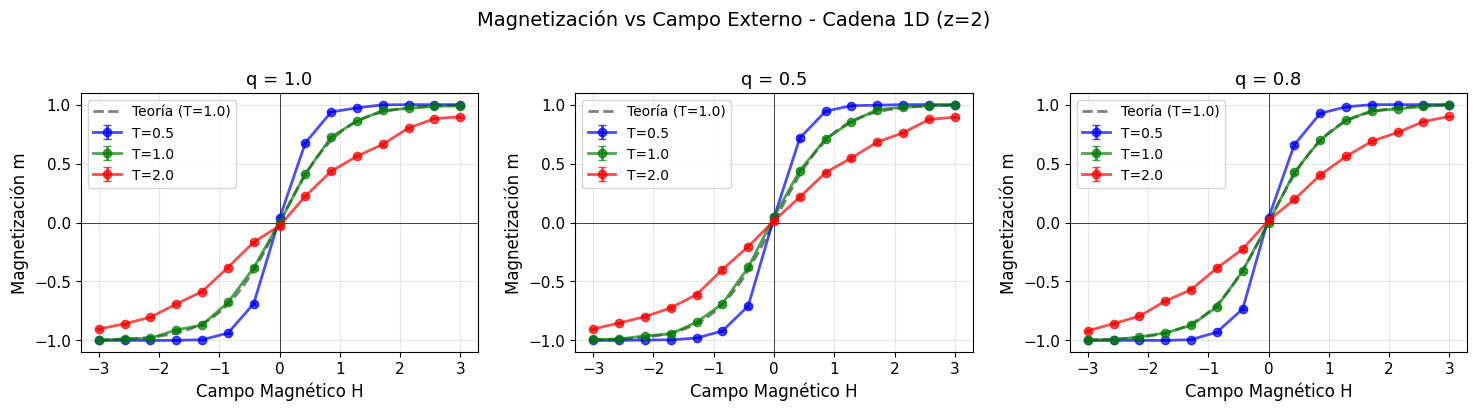


Simulando Red Hexagonal 2D (z=6)...


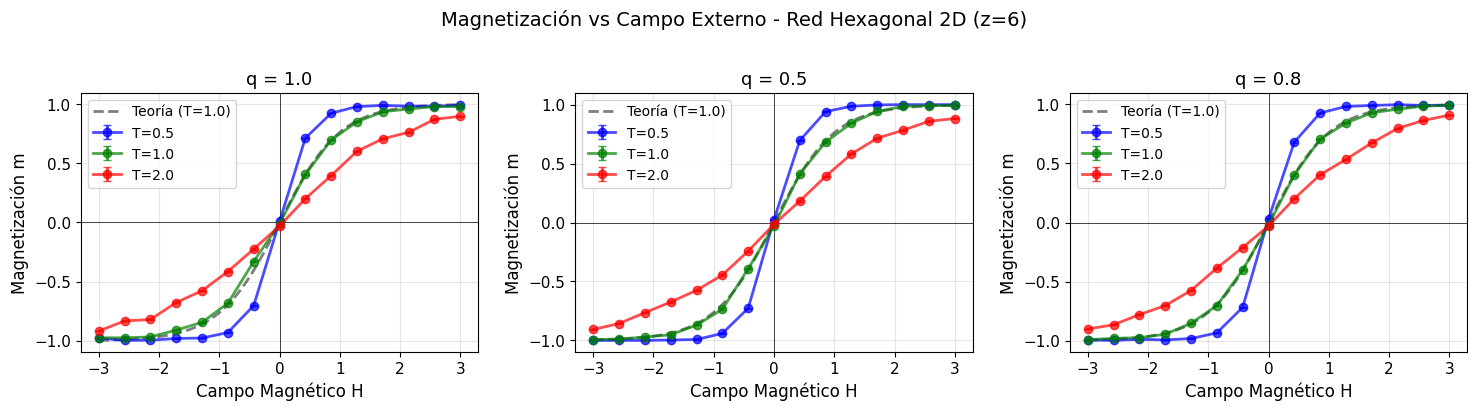


Simulando Red Cuadrada 2D (z=4)...


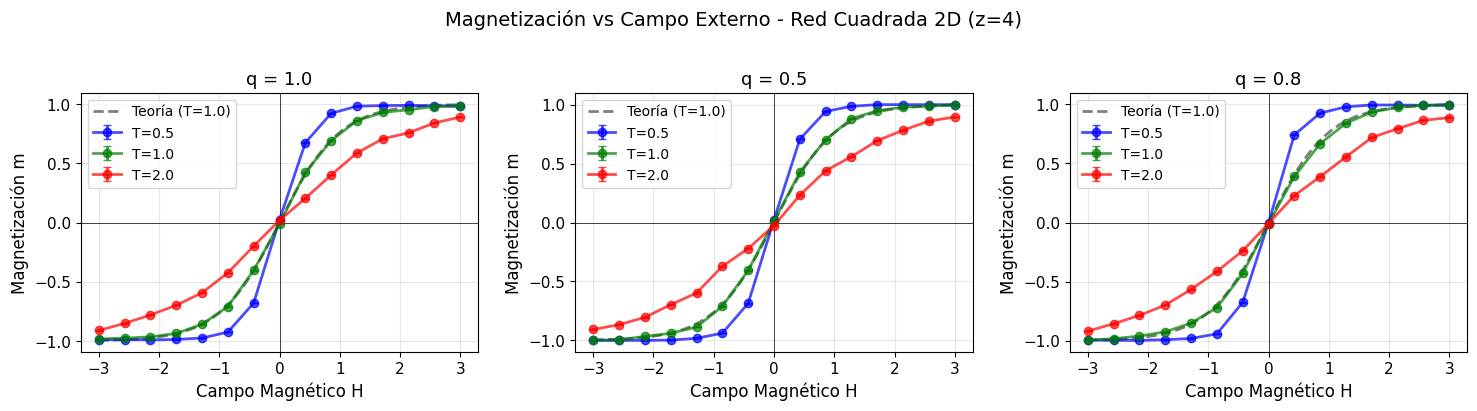


Simulando Red BCC 3D (z=8)...


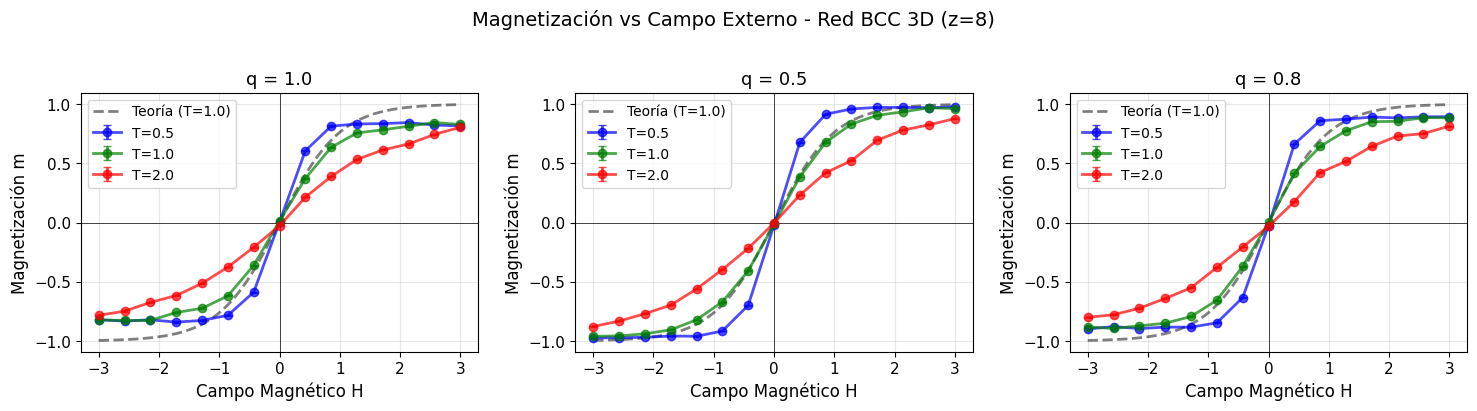

In [10]:
# Simulación para cada tipo de red y valor de q
for lattice_class, L, name in lattice_configs:
    print(f"Simulando {name}...")
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    fig.suptitle(f'Magnetización vs Campo Externo - {name}', fontsize=14, y=1.02)
    
    for idx, q in enumerate(q_values):
        ax = axes[idx]
        results, errors = simulate_magnetization_vs_field(lattice_class, L, q, J=0.0, 
                                                          temperatures=temperatures, 
                                                          H_values=H_values, n_steps=4000)
        
        colors = ['blue', 'green', 'red']
        for T, color in zip(temperatures, colors):
            ax.errorbar(H_values, results[T], yerr=errors[T], 
                       fmt='o-', color=color, label=f'T={T}', alpha=0.7, capsize=3)
        
        # Curva teórica para la temperatura intermedia
        H_theory = np.linspace(-3, 3, 100)
        m_theory = theoretical_magnetization(H_theory, temperatures[1])
        ax.plot(H_theory, m_theory, 'k--', label='Teoría (T=1.0)', alpha=0.5)
        
        ax.set_xlabel('Campo Magnético H')
        ax.set_ylabel('Magnetización m')
        ax.set_title(f'q = {q}')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
        ax.axvline(x=0, color='k', linestyle='-', linewidth=0.5)
    
    plt.tight_layout()
    plt.show()
    print()

#### 4.1.2 Evolución de la Energía Interna

Analizando evolución de la energía interna (Red Cuadrada 2D, q=1.0)...



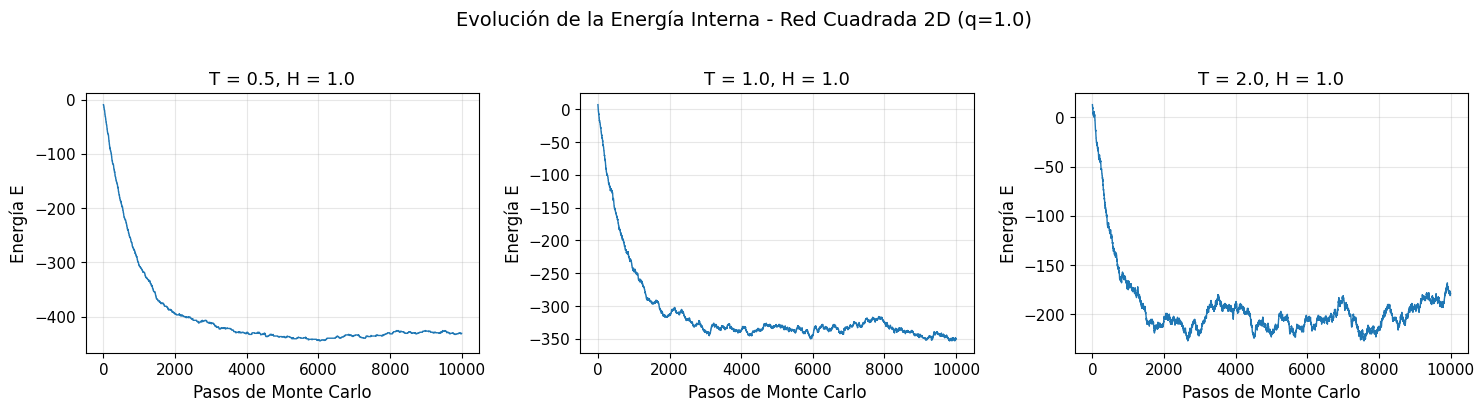

In [11]:
# Análisis de relajación del sistema (ejemplo con red cuadrada 2D)
print("Analizando evolución de la energía interna (Red Cuadrada 2D, q=1.0)...\n")

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle('Evolución de la Energía Interna - Red Cuadrada 2D (q=1.0)', fontsize=14, y=1.02)

H_test = 1.0
n_steps_relax = 10000

for idx, T in enumerate(temperatures):
    lattice = SquareLattice2D(L_2d, q=1.0, J=0.0)
    energies, _ = lattice.simulate(T, H_test, n_steps_relax, n_equilibration=0)
    
    ax = axes[idx]
    ax.plot(energies, linewidth=1)
    ax.set_xlabel('Pasos de Monte Carlo')
    ax.set_ylabel('Energía E')
    ax.set_title(f'T = {T}, H = {H_test}')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### 4.1.3 Ley de Estados Correspondientes

Verificando ley de estados correspondientes...



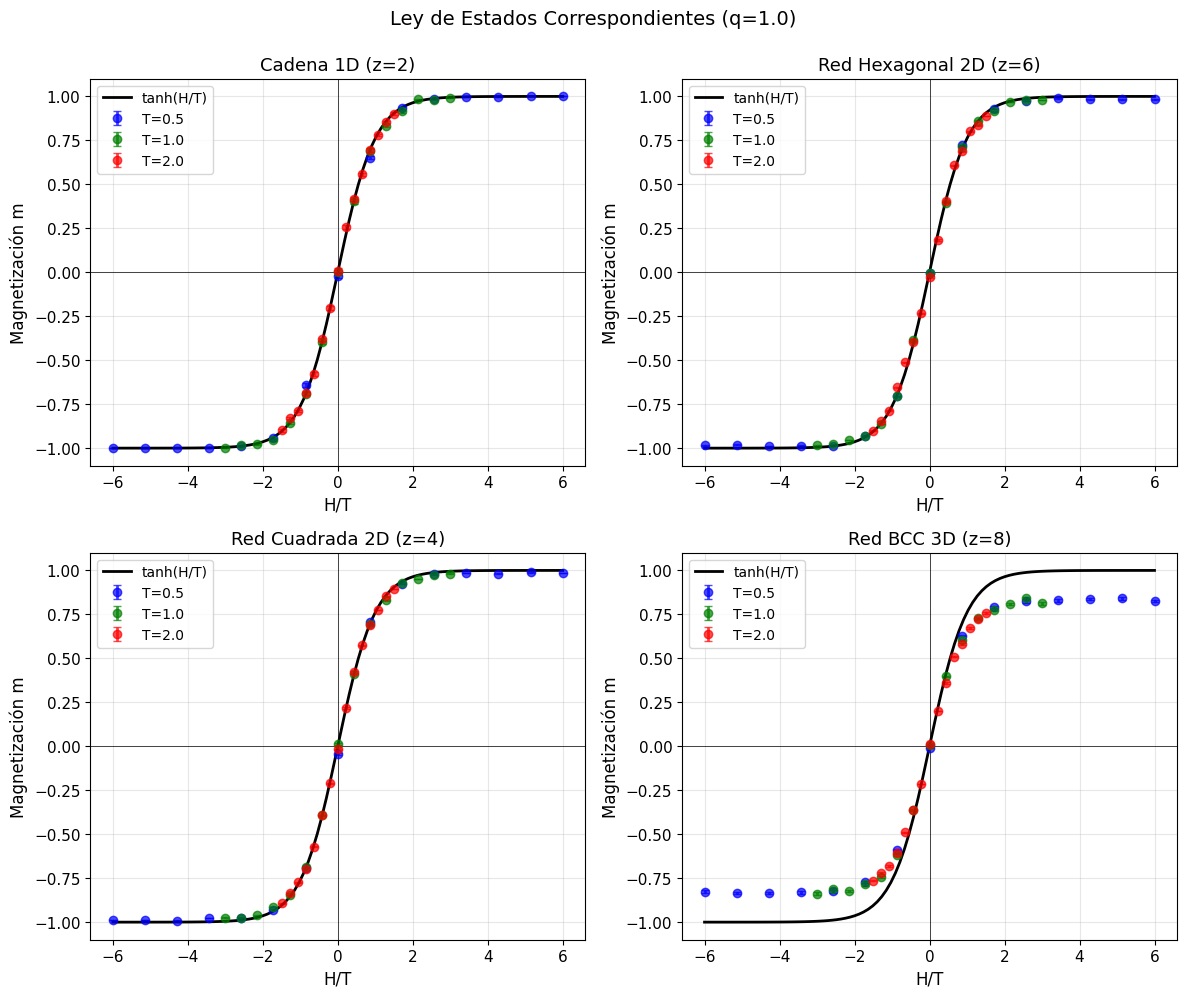


Análisis cuantitativo del ajuste a la función teórica tanh(H/T):
----------------------------------------------------------------------
Cadena 1D (z=2):
  RMSE = 0.012840
  R² = 0.999761

Cadena 1D (z=2):
  RMSE = 0.012840
  R² = 0.999761

Red Hexagonal 2D (z=6):
  RMSE = 0.018048
  R² = 0.999519

Red Hexagonal 2D (z=6):
  RMSE = 0.018048
  R² = 0.999519

Red Cuadrada 2D (z=4):
  RMSE = 0.016488
  R² = 0.999598

Red Cuadrada 2D (z=4):
  RMSE = 0.016488
  R² = 0.999598

Red BCC 3D (z=8):
  RMSE = 0.129169
  R² = 0.966137

Red BCC 3D (z=8):
  RMSE = 0.129169
  R² = 0.966137



In [12]:
# Verificación de la ley de estados correspondientes
print("Verificando ley de estados correspondientes...\n")

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Ley de Estados Correspondientes (q=1.0)', fontsize=14, y=0.995)

for idx, (lattice_class, L, name) in enumerate(lattice_configs):
    ax = axes[idx // 2, idx % 2]
    
    results, errors = simulate_magnetization_vs_field(lattice_class, L, q=1.0, J=0.0,
                                                      temperatures=temperatures,
                                                      H_values=H_values, n_steps=4000)
    
    colors = ['blue', 'green', 'red']
    for T, color in zip(temperatures, colors):
        H_over_T = H_values / T
        error_over_T = errors[T]  # Los errores no escalan con T
        ax.errorbar(H_over_T, results[T], yerr=error_over_T,
                   fmt='o', color=color, label=f'T={T}', alpha=0.7, capsize=3)
    
    # Curva teórica universal
    x_theory = np.linspace(-6, 6, 100)
    y_theory = np.tanh(x_theory)
    ax.plot(x_theory, y_theory, 'k-', label='tanh(H/T)', linewidth=2)
    
    ax.set_xlabel('H/T')
    ax.set_ylabel('Magnetización m')
    ax.set_title(name)
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
    ax.axvline(x=0, color='k', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.show()

# Análisis cuantitativo del ajuste a tanh(x)
print("\nAnálisis cuantitativo del ajuste a la función teórica tanh(H/T):")
print("-" * 70)

for lattice_class, L, name in lattice_configs:
    results, _ = simulate_magnetization_vs_field(lattice_class, L, q=1.0, J=0.0,
                                                 temperatures=[1.0],
                                                 H_values=H_values, n_steps=4000)
    
    m_sim = results[1.0]
    m_theory = theoretical_magnetization(H_values, 1.0)
    
    # Calcula error cuadrático medio
    rmse = np.sqrt(np.mean((m_sim - m_theory)**2))
    
    # Calcula coeficiente de determinación R²
    ss_res = np.sum((m_sim - m_theory)**2)
    ss_tot = np.sum((m_sim - np.mean(m_sim))**2)
    r_squared = 1 - (ss_res / ss_tot)
    
    print(f"{name}:")
    print(f"  RMSE = {rmse:.6f}")
    print(f"  R² = {r_squared:.6f}")
    print()

#### 4.1.4 Efecto del Número de Coordinación y Dilución Magnética

Analizando efectos de número de coordinación y dilución magnética...



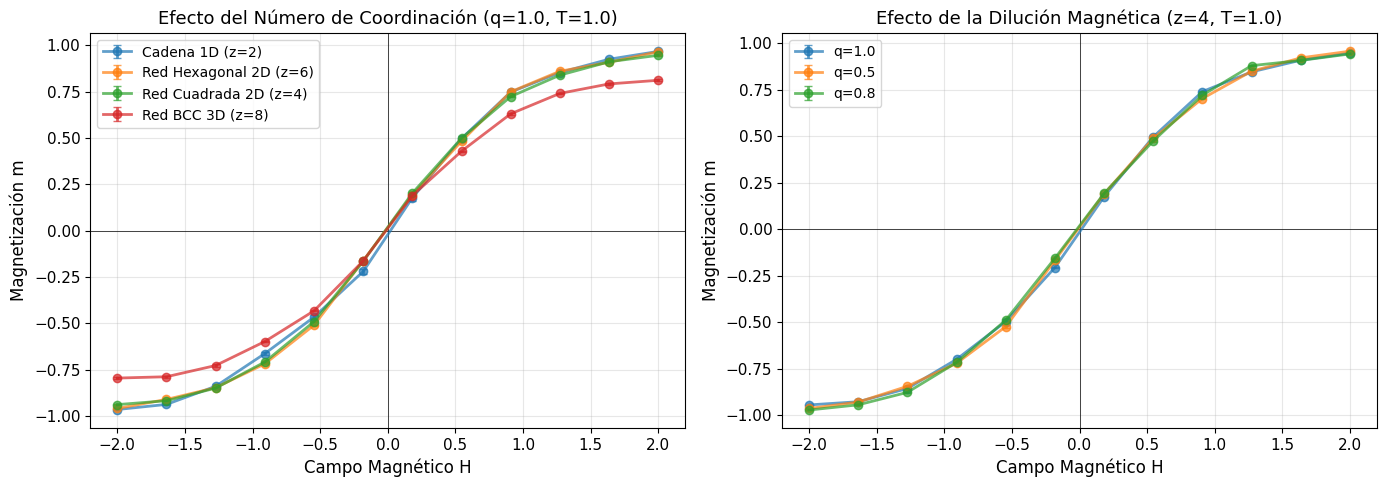


Conclusión del análisis paramagnético:
----------------------------------------------------------------------
En el caso paramagnético (J=0), el número de coordinación z no afecta
significativamente la respuesta magnética, ya que no hay interacción entre
espines. La dilución magnética (q) solo modifica el número efectivo de
momentos magnéticos, pero la forma funcional m = tanh(H/T) se mantiene.



In [13]:
# Análisis comparativo del efecto de z y q
print("Analizando efectos de número de coordinación y dilución magnética...\n")

T_fixed = 1.0
H_range = np.linspace(-2, 2, 12)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Efecto del número de coordinación (q=1.0)
ax1 = axes[0]
z_values = []
for lattice_class, L, name in lattice_configs:
    results, errors = simulate_magnetization_vs_field(lattice_class, L, q=1.0, J=0.0,
                                                      temperatures=[T_fixed],
                                                      H_values=H_range, n_steps=4000)
    ax1.errorbar(H_range, results[T_fixed], yerr=errors[T_fixed],
                fmt='o-', label=name, alpha=0.7, capsize=3)
    z_values.append(lattice_class(L, q=1.0).z)

ax1.set_xlabel('Campo Magnético H')
ax1.set_ylabel('Magnetización m')
ax1.set_title(f'Efecto del Número de Coordinación (q=1.0, T={T_fixed})')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
ax1.axvline(x=0, color='k', linestyle='-', linewidth=0.5)

# Efecto de la dilución magnética (Red Cuadrada 2D, z=4)
ax2 = axes[1]
for q in q_values:
    results, errors = simulate_magnetization_vs_field(SquareLattice2D, L_2d, q=q, J=0.0,
                                                      temperatures=[T_fixed],
                                                      H_values=H_range, n_steps=4000)
    ax2.errorbar(H_range, results[T_fixed], yerr=errors[T_fixed],
                fmt='o-', label=f'q={q}', alpha=0.7, capsize=3)

ax2.set_xlabel('Campo Magnético H')
ax2.set_ylabel('Magnetización m')
ax2.set_title(f'Efecto de la Dilución Magnética (z=4, T={T_fixed})')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
ax2.axvline(x=0, color='k', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.show()

print("\nConclusión del análisis paramagnético:")
print("-" * 70)
print("En el caso paramagnético (J=0), el número de coordinación z no afecta")
print("significativamente la respuesta magnética, ya que no hay interacción entre")
print("espines. La dilución magnética (q) solo modifica el número efectivo de")
print("momentos magnéticos, pero la forma funcional m = tanh(H/T) se mantiene.")
print()

### 4.2 Caso Ferromagnético (J=1)

#### 4.2.1 Fenómeno de Histéresis

Simulando ciclos de histéresis para caso ferromagnético (J=1.0)...

Analizando histéresis para Red Cuadrada 2D (z=4)
Parámetros de histéresis:
T      q      H_c (coercitividad)    m_r (remanencia)    
------------------------------------------------------------
1.0    1.0    -2.0302                -1.0000             
1.0    1.0    -2.0302                -1.0000             
1.0    0.5    -0.4263                -0.6767             
1.0    0.5    -0.4263                -0.6767             
1.0    0.8    -1.3256                -0.9628             
1.0    0.8    -1.3256                -0.9628             
2.0    1.0    -1.1911                -0.9580             
2.0    1.0    -1.1911                -0.9580             
2.0    0.5    -0.1338                -0.2362             
2.0    0.5    -0.1338                -0.2362             
2.0    0.8    -0.6906                -0.7674             

2.0    0.8    -0.6906                -0.7674             



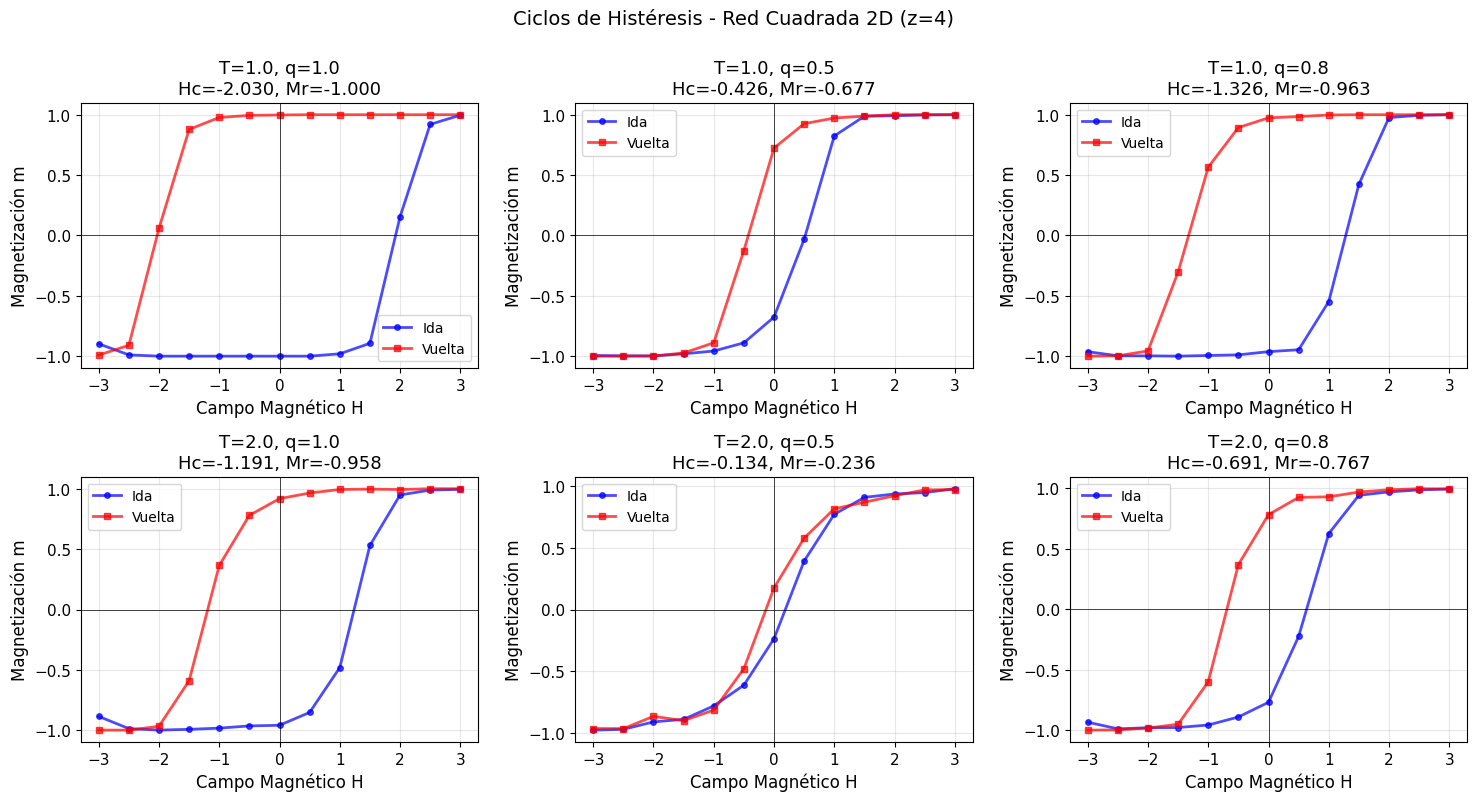


Analizando histéresis para Red Hexagonal 2D (z=6)
Parámetros de histéresis:
T      q      H_c (coercitividad)    m_r (remanencia)    
------------------------------------------------------------
1.0    1.0    0.0000                 -1.0000             
1.0    1.0    0.0000                 -1.0000             
1.0    0.5    -0.8953                -0.9058             
1.0    0.5    -0.8953                -0.9058             
1.0    0.8    -2.1630                -1.0000             
1.0    0.8    -2.1630                -1.0000             
2.0    1.0    -2.4523                -0.9962             
2.0    1.0    -2.4523                -0.9962             
2.0    0.5    -0.4021                -0.4742             
2.0    0.5    -0.4021                -0.4742             
2.0    0.8    -1.5558                -0.9596             

2.0    0.8    -1.5558                -0.9596             



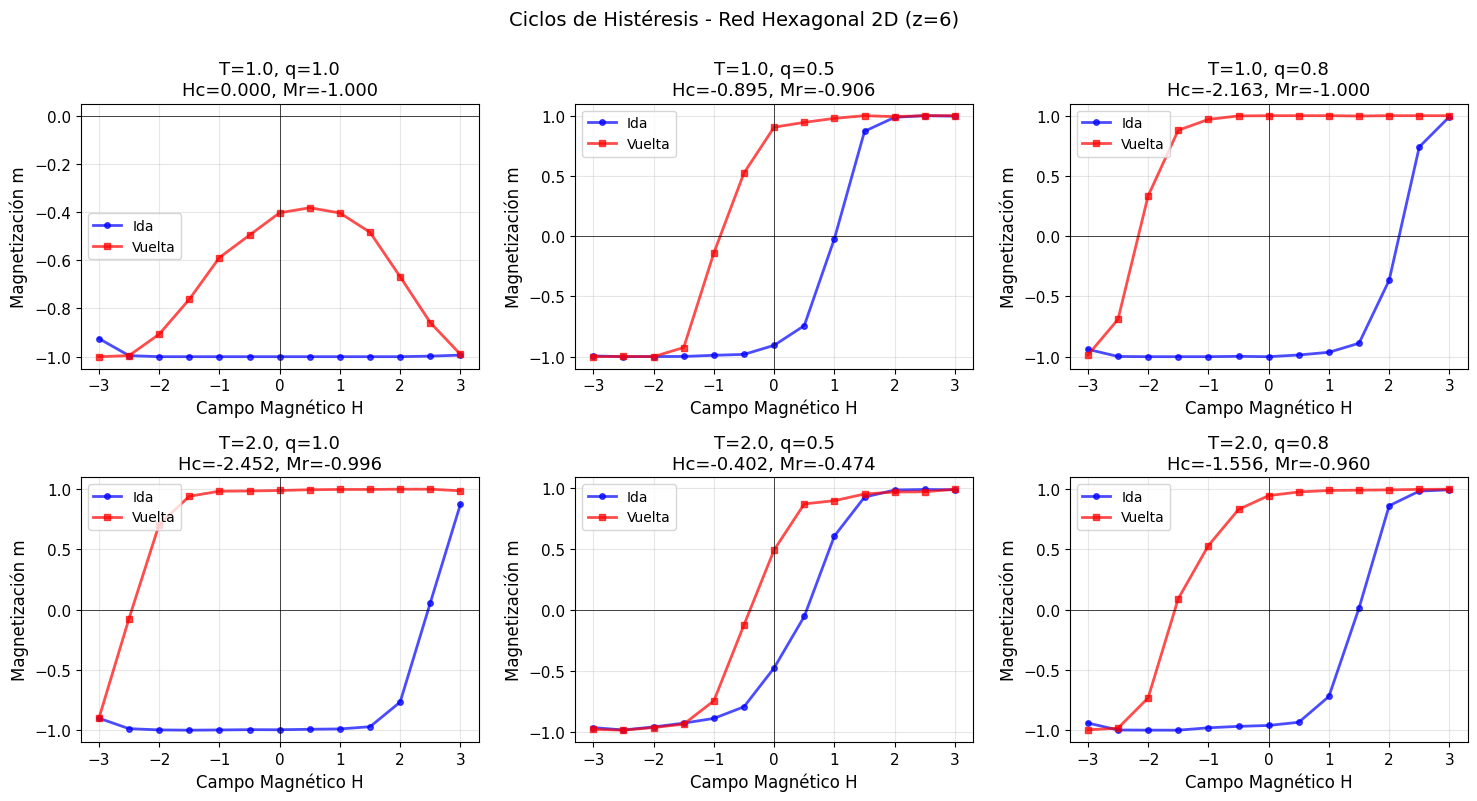

In [14]:
print("Simulando ciclos de histéresis para caso ferromagnético (J=1.0)...\n")

T_hysteresis = [1.0, 2.0]
H_hyst_range = np.linspace(-3, 3, 13)

# Seleccionar algunas redes para análisis de histéresis
hyst_configs = [
    (SquareLattice2D, L_2d, 'Red Cuadrada 2D (z=4)'),
    (HexagonalLattice2D, L_2d, 'Red Hexagonal 2D (z=6)')
]

for lattice_class, L, name in hyst_configs:
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    fig.suptitle(f'Ciclos de Histéresis - {name}', fontsize=14, y=0.998)
    
    print(f"Analizando histéresis para {name}")
    print("Parámetros de histéresis:")
    print(f"{'T':<6} {'q':<6} {'H_c (coercitividad)':<22} {'m_r (remanencia)':<20}")
    print("-" * 60)
    
    for row_idx, T in enumerate(T_hysteresis):
        for col_idx, q in enumerate(q_values):
            ax = axes[row_idx, col_idx]
            
            H_cycle, m_cycle = simulate_hysteresis(lattice_class, L, q, J=1.0, T=T,
                                                     H_values=H_hyst_range, n_steps=2000)
            
            # Calcular coercitividad y remanencia
            H_c, m_r = calculate_coercivity_and_remanence(H_cycle, m_cycle)
            print(f"{T:<6.1f} {q:<6.1f} {H_c:<22.4f} {m_r:<20.4f}")
            
            # Separar ida y vuelta
            mid = len(H_cycle) // 2
            ax.plot(H_cycle[:mid], m_cycle[:mid], 'b-o', label='Ida', markersize=4, alpha=0.7)
            ax.plot(H_cycle[mid:], m_cycle[mid:], 'r-s', label='Vuelta', markersize=4, alpha=0.7)
            
            ax.set_xlabel('Campo Magnético H')
            ax.set_ylabel('Magnetización m')
            ax.set_title(f'T={T}, q={q}\nHc={H_c:.3f}, Mr={m_r:.3f}')
            ax.legend()
            ax.grid(True, alpha=0.3)
            ax.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
            ax.axvline(x=0, color='k', linestyle='-', linewidth=0.5)
    
    print()
    plt.tight_layout()
    plt.show()
    print()

#### 4.2.2 Transición de Fase: Magnetización vs Temperatura

Simulando curvas de magnetización vs temperatura con annealing...
MÉTODO CORRECTO: Sistema ordenado inicial + reutilización (annealing)

Temperaturas críticas estimadas (J=1.0):
Red                            q      T_c estimada    T_c teórica     Diferencia     

Simulando Cadena 1D (z=2)...
  q=1.0... 

Cadena 1D (z=2)                1.0    Sin transición  ---             d=1            
OK
  q=0.5... Cadena 1D (z=2)                0.5    Sin transición  ---             d=1            
OK
  q=0.8... Cadena 1D (z=2)                0.5    Sin transición  ---             d=1            
OK
  q=0.8... Cadena 1D (z=2)                0.8    Sin transición  ---             d=1            
OK
Cadena 1D (z=2)                0.8    Sin transición  ---             d=1            
OK


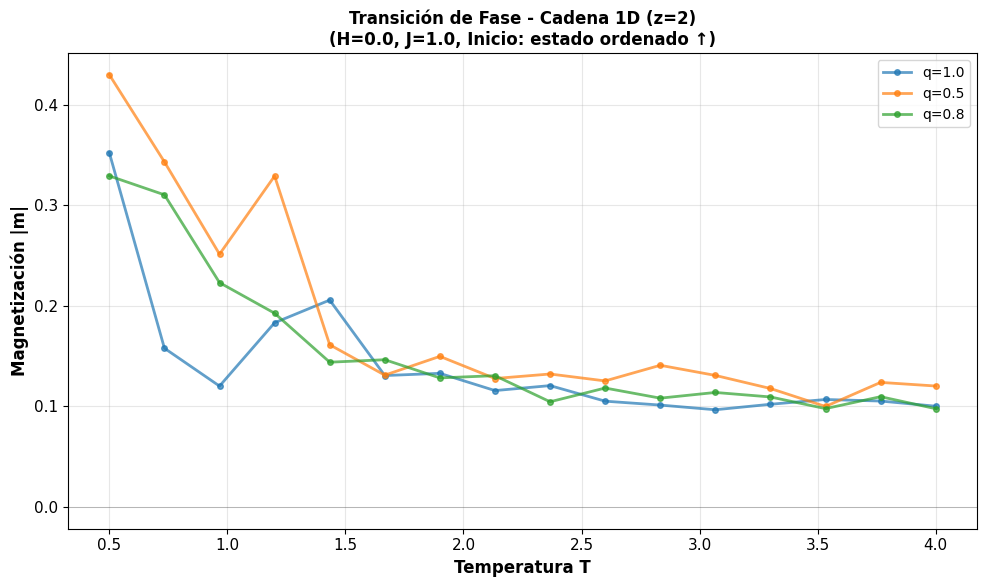


Simulando Red Hexagonal 2D (z=6)...
  q=1.0... Red Hexagonal 2D (z=6)         1.0    1.000           1.52            34.2          %
OK
  q=0.5... Red Hexagonal 2D (z=6)         1.0    1.000           1.52            34.2          %
OK
  q=0.5... Red Hexagonal 2D (z=6)         0.5    1.000           ---             ---            
OK
  q=0.8... Red Hexagonal 2D (z=6)         0.5    1.000           ---             ---            
OK
  q=0.8... Red Hexagonal 2D (z=6)         0.8    1.000           ---             ---            
OK
Red Hexagonal 2D (z=6)         0.8    1.000           ---             ---            
OK


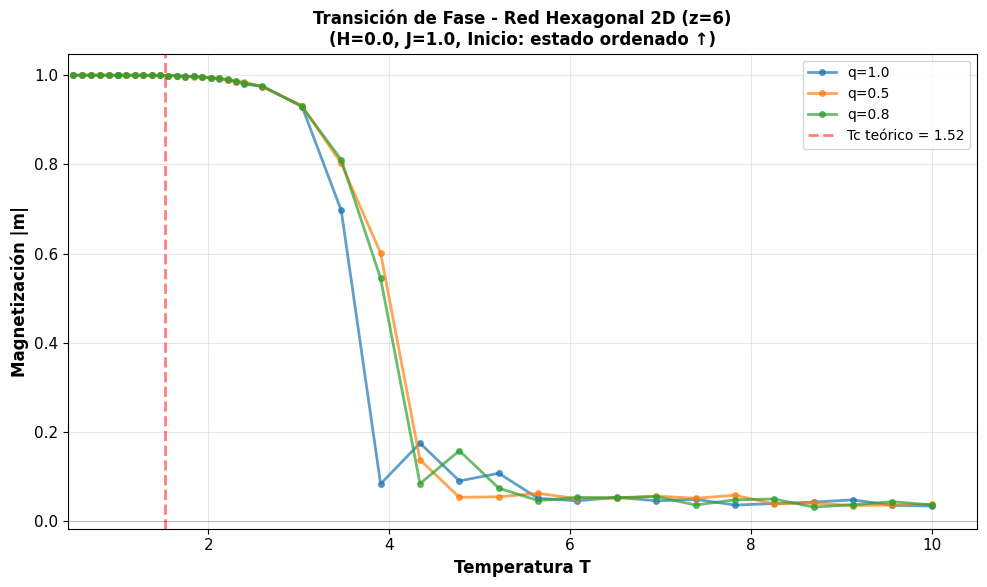


Simulando Red Cuadrada 2D (z=4)...
  q=1.0... Red Cuadrada 2D (z=4)          1.0    1.800           2.27            20.7          %
OK
  q=0.5... Red Cuadrada 2D (z=4)          1.0    1.800           2.27            20.7          %
OK
  q=0.5... Red Cuadrada 2D (z=4)          0.5    1.800           ---             ---            
OK
  q=0.8... Red Cuadrada 2D (z=4)          0.5    1.800           ---             ---            
OK
  q=0.8... Red Cuadrada 2D (z=4)          0.8    1.800           ---             ---            
OK
Red Cuadrada 2D (z=4)          0.8    1.800           ---             ---            
OK


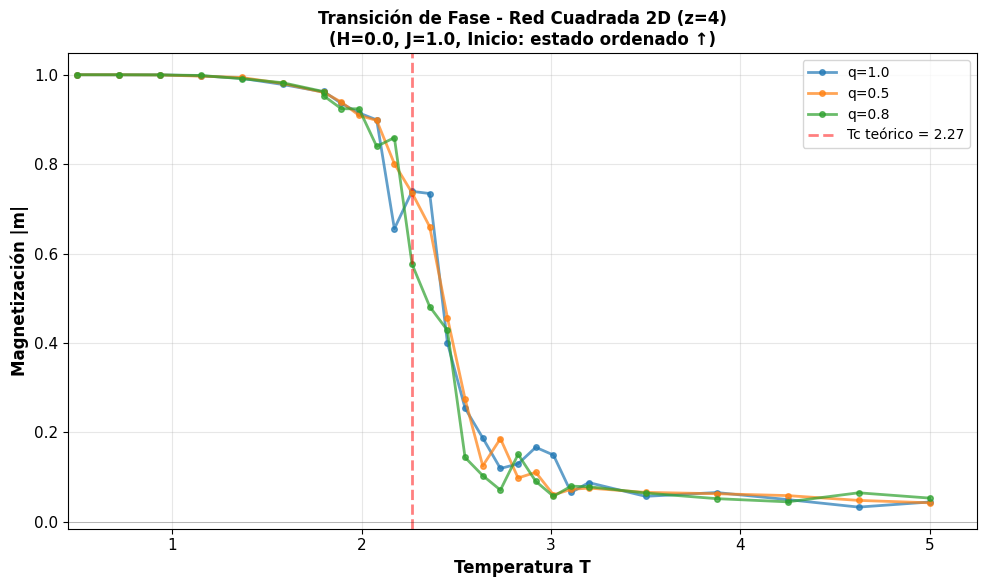


Simulando Red BCC 3D (z=8)...
  q=1.0... Red BCC 3D (z=8)               1.0    5.500           6.30            12.7          %
OK
  q=0.5... Red BCC 3D (z=8)               1.0    5.500           6.30            12.7          %
OK
  q=0.5... Red BCC 3D (z=8)               0.5    5.500           ---             ---            
OK
  q=0.8... Red BCC 3D (z=8)               0.5    5.500           ---             ---            
OK
  q=0.8... Red BCC 3D (z=8)               0.8    5.500           ---             ---            
OK
Red BCC 3D (z=8)               0.8    5.500           ---             ---            
OK


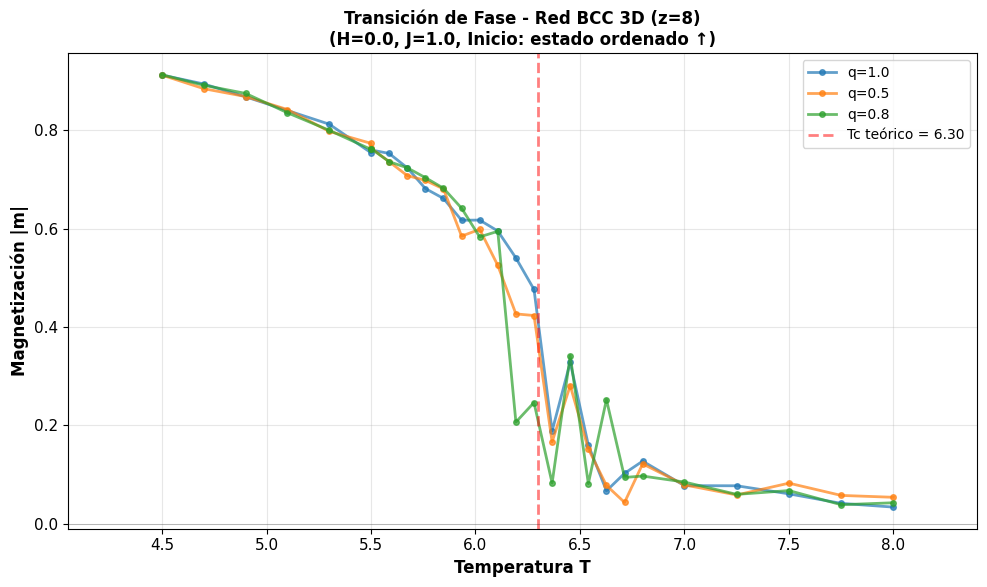


RESUMEN TEÓRICO:
1. Red Cuadrada 2D: Tc/J = 2.269 (solución exacta Onsager)
2. Red Hexagonal 2D: Tc/J ≈ 1.52
3. Red BCC 3D: Tc/J ≈ 6.3 (campo medio)
4. Cadena 1D: NO presenta transición a T>0 (teorema Mermin-Wagner)
5. Dilución (q<1) reduce Tc; para q<qc_percolación, elimina transición

Diferencias con teoría:
- Efectos de tamaño finito (redes pequeñas → Tc ligeramente distinto)
- Tiempos de equilibración finitos (no es límite termodinámico)


In [15]:
print("Simulando curvas de magnetización vs temperatura con annealing...")
print("MÉTODO CORRECTO: Sistema ordenado inicial + reutilización (annealing)\n")

# Rangos de temperatura optimizados por red (más densos cerca de Tc)
T_range_fine = {
    'Chain1D': np.linspace(0.5, 4.0, 16),
    'SquareLattice2D': np.concatenate([
        np.linspace(0.5, 1.8, 7),
        np.linspace(1.8, 3.2, 16),
        np.linspace(3.5, 5.0, 5)
    ]),
    'HexagonalLattice2D': np.concatenate([
        np.linspace(0.5, 1.0, 6),
        np.linspace(1.0, 2.4, 16),
        np.linspace(2.6, 10.0, 18)
    ]),
    'BCCLattice3D': np.concatenate([
        np.linspace(4.5, 5.5, 6),
        np.linspace(5.5, 6.8, 16),
        np.linspace(7.0, 8.0, 5)
    ])
}

H_fixed = 0.0

print("Temperaturas críticas estimadas (J=1.0):")
print("="*90)
print(f"{'Red':<30} {'q':<6} {'T_c estimada':<15} {'T_c teórica':<15} {'Diferencia':<15}")
print("="*90)

# Temperaturas críticas teóricas
Tc_theory = {
    'Chain1D': None,  # No tiene transición
    'SquareLattice2D': 2.269,
    'HexagonalLattice2D': 1.52,
    'BCCLattice3D': 6.3
}

for lattice_class, L, name in lattice_configs:
    class_name = lattice_class.__name__
    T_range = T_range_fine.get(class_name, np.linspace(0.5, 4.0, 20))
    
    print(f"\nSimulando {name}...")
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for q in q_values:
        print(f"  q={q}... ", end='', flush=True)
        
        # Usar función corregida con annealing
        T_vals, m_vals = simulate_magnetization_vs_temperature_annealing(
            lattice_class, L, q, J=1.0, T_values=T_range, H=H_fixed,
            eq_sweeps=400, meas_sweeps=600
        )
        
        ax.plot(T_vals, m_vals, 'o-', label=f'q={q}', alpha=0.7, markersize=4, linewidth=2)
        
        # Estima Tc buscando la máxima derivada
        if class_name != 'Chain1D':
            dM_dT = np.gradient(m_vals, T_vals)
            idx_critical = np.argmin(dM_dT)
            T_c = T_vals[idx_critical]
            
            Tc_th = Tc_theory.get(class_name, None)
            if q == 1.0 and Tc_th:
                diff = abs(T_c - Tc_th)
                diff_pct = 100 * diff / Tc_th
                print(f"{name:<30} {q:<6.1f} {T_c:<15.3f} {Tc_th:<15.2f} {diff_pct:<14.1f}%")
            else:
                print(f"{name:<30} {q:<6.1f} {T_c:<15.3f} {'---':<15} {'---':<15}")
        else:
            print(f"{name:<30} {q:<6.1f} {'Sin transición':<15} {'---':<15} {'d=1':<15}")
        
        print("OK")
    
    # Añadir línea teórica si existe
    Tc_th = Tc_theory.get(class_name)
    if Tc_th:
        ax.axvline(Tc_th, color='red', linestyle='--', linewidth=2, 
                  alpha=0.5, label=f'Tc teórico = {Tc_th:.2f}')
    
    ax.set_xlabel('Temperatura T', fontsize=12, fontweight='bold')
    ax.set_ylabel('Magnetización |m|', fontsize=12, fontweight='bold')
    ax.set_title(f'Transición de Fase - {name}\n(H={H_fixed}, J=1.0, Inicio: estado ordenado ↑)', 
                fontsize=12, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='k', linestyle='-', linewidth=0.5, alpha=0.3)
    
    if Tc_th:
        ax.set_xlim(left=min(T_range)*0.9, right=max(T_range)*1.05)
    
    plt.tight_layout()
    plt.show()

print("\n" + "="*90)
print("RESUMEN TEÓRICO:")
print("="*90)
print("1. Red Cuadrada 2D: Tc/J = 2.269 (solución exacta Onsager)")
print("2. Red Hexagonal 2D: Tc/J ≈ 1.52")
print("3. Red BCC 3D: Tc/J ≈ 6.3 (campo medio)")
print("4. Cadena 1D: NO presenta transición a T>0 (teorema Mermin-Wagner)")
print("5. Dilución (q<1) reduce Tc; para q<qc_percolación, elimina transición")
print("\nDiferencias con teoría:")
print("- Efectos de tamaño finito (redes pequeñas → Tc ligeramente distinto)")
print("- Tiempos de equilibración finitos (no es límite termodinámico)")
print("="*90)

#### 4.2.3 Visualización de Microestados Magnéticos

Generando snapshots de microestados magnéticos (Red Cuadrada 2D)...



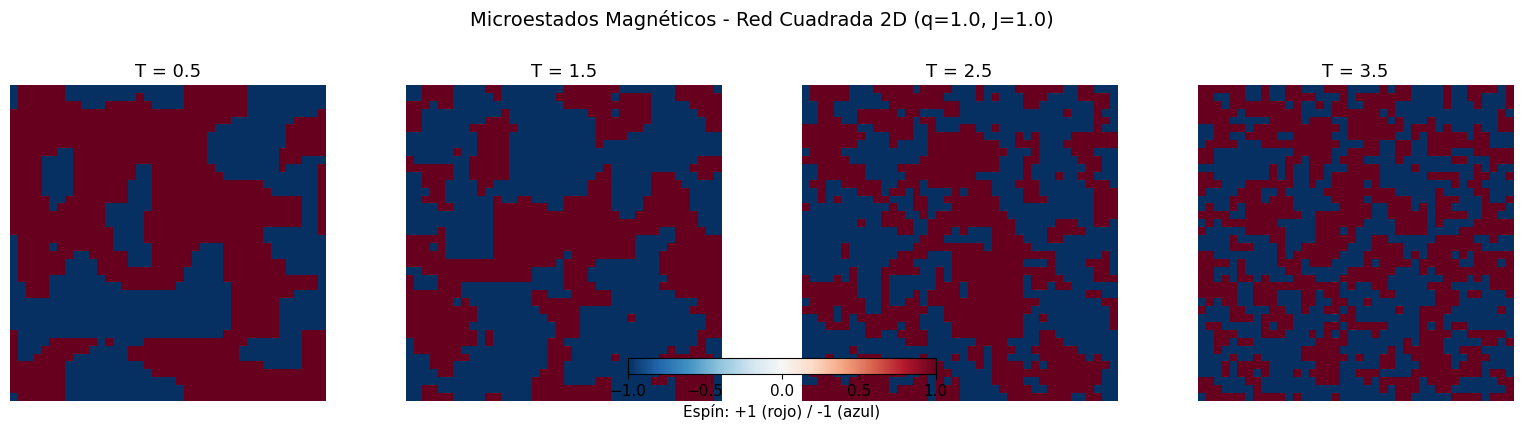


Observaciones de los microestados:
----------------------------------------------------------------------
T = 0.5: Sistema ordenado con dominios ferromagnéticos extensos.
T = 1.5: Presencia de dominios con fluctuaciones térmicas moderadas.
T = 2.5: Cerca de la transición, dominios de diferentes tamaños coexisten.
T = 3.5: Estado paramagnético con configuración esencialmente aleatoria.



In [16]:
print("Generando snapshots de microestados magnéticos (Red Cuadrada 2D)...\n")

T_snapshots = [0.5, 1.5, 2.5, 3.5]
L_snapshot = 40
q_snapshot = 1.0

fig, axes = plt.subplots(1, 4, figsize=(16, 4))
fig.suptitle(f'Microestados Magnéticos - Red Cuadrada 2D (q={q_snapshot}, J=1.0)', fontsize=14, y=1.02)

for idx, T in enumerate(T_snapshots):
    lattice = SquareLattice2D(L_snapshot, q=q_snapshot, J=1.0)
    lattice.simulate(T, H=0.0, n_steps=8000, n_equilibration=2000)
    
    config = lattice.get_2d_configuration()
    
    ax = axes[idx]
    im = ax.imshow(config, cmap='RdBu_r', vmin=-1, vmax=1, interpolation='nearest')
    ax.set_title(f'T = {T}')
    ax.axis('off')

# Agregar barra de color
cbar = fig.colorbar(im, ax=axes, orientation='horizontal', fraction=0.05, pad=0.05)
cbar.set_label('Espín: +1 (rojo) / -1 (azul)', fontsize=11)

plt.tight_layout()
plt.show()

print("\nObservaciones de los microestados:")
print("-" * 70)
print("T = 0.5: Sistema ordenado con dominios ferromagnéticos extensos.")
print("T = 1.5: Presencia de dominios con fluctuaciones térmicas moderadas.")
print("T = 2.5: Cerca de la transición, dominios de diferentes tamaños coexisten.")
print("T = 3.5: Estado paramagnético con configuración esencialmente aleatoria.")
print()

#### 4.2.4 Análisis de Temperatura Crítica

Estimación de temperaturas críticas y análisis de escalamiento...

Simulando Cadena 1D (z=2) para análisis Tc vs z...
Simulando Red Hexagonal 2D (z=6) para análisis Tc vs z...
Simulando Red Hexagonal 2D (z=6) para análisis Tc vs z...
Simulando Red Cuadrada 2D (z=4) para análisis Tc vs z...
Simulando Red Cuadrada 2D (z=4) para análisis Tc vs z...
Simulando Red BCC 3D (z=8) para análisis Tc vs z...
Simulando Red BCC 3D (z=8) para análisis Tc vs z...
Simulando Red Cuadrada con q=1.0 para análisis Tc vs q...
Simulando Red Cuadrada con q=1.0 para análisis Tc vs q...
Simulando Red Cuadrada con q=0.8 para análisis Tc vs q...
Simulando Red Cuadrada con q=0.8 para análisis Tc vs q...
Simulando Red Cuadrada con q=0.5 para análisis Tc vs q...
Simulando Red Cuadrada con q=0.5 para análisis Tc vs q...


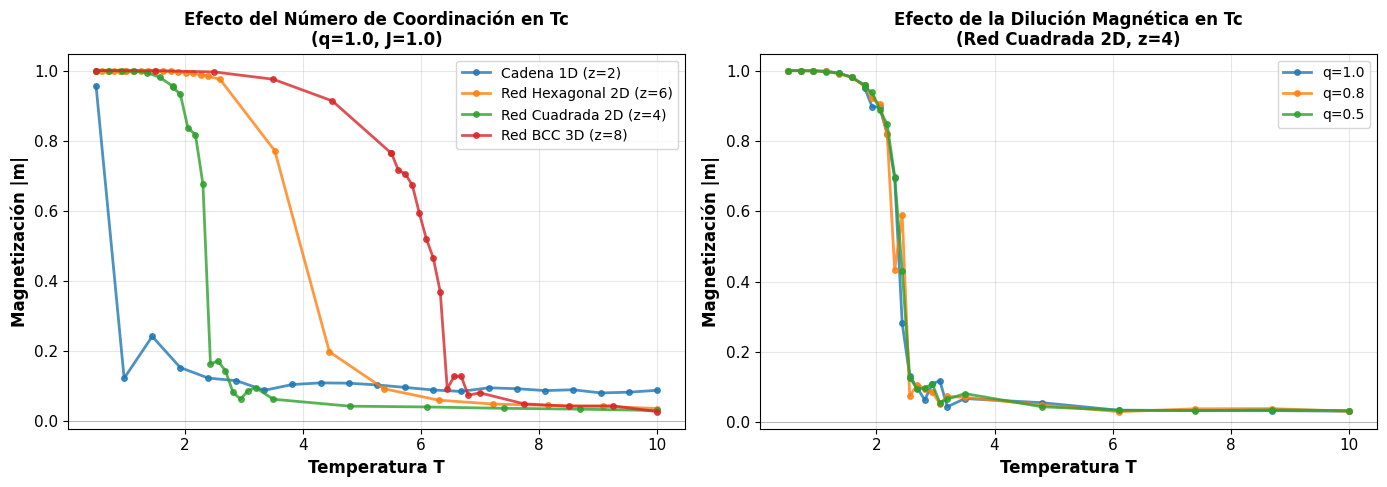


ANÁLISIS DE DEPENDENCIAS

1. Dependencia de Tc con el número de coordinación z (q=1.0):
--------------------------------------------------------------------------------
z          T_c/J           Tipo de red                    T_c teórico    
--------------------------------------------------------------------------------
4          1.800           Red Cuadrada 2D                2.269          
6          1.000           Red Hexagonal 2D               1.52           
8          5.500           Red BCC 3D                     6.3            

2. Dependencia de Tc con la dilución magnética q (Red Cuadrada 2D, z=4):
--------------------------------------------------------------------------------
q          T_c/J           Reducción respecto a q=1      
--------------------------------------------------------------------------------
1.0        1.800           0.0                          %
0.8        1.800           0.0                          %
0.5        1.800           0.0             

In [17]:
print("Estimación de temperaturas críticas y análisis de escalamiento...\n")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ============================================================
# Panel izquierdo: Efecto del número de coordinación (q=1.0)
# ============================================================
ax1 = axes[0]
Tc_vs_z = {}

# Rangos de temperatura adaptados por red (reciclando los óptimos)
T_ranges = {
    'Chain1D': np.linspace(0.5, 10.0, 21),
    'HexagonalLattice2D': np.concatenate([
        np.linspace(0.5, 1.0, 6),
        np.linspace(1.0, 2.4, 12),
        np.linspace(2.6, 10.0, 9)
    ]),
    'SquareLattice2D': np.concatenate([
        np.linspace(0.5, 1.8, 7),
        np.linspace(1.8, 3.2, 12),
        np.linspace(3.5, 10.0, 6)
    ]),
    'BCCLattice3D': np.concatenate([
        np.linspace(0.5, 5.5, 6),
        np.linspace(5.5, 6.8, 12),
        np.linspace(7.0, 10.0, 5)
    ])
}

for lattice_class, L, name in lattice_configs:
    class_name = lattice_class.__name__
    T_vals_net = T_ranges.get(class_name, np.linspace(0.5, 4.0, 20))
    
    print(f"Simulando {name} para análisis Tc vs z...")
    
    # Usar función corregida con annealing
    T_vals, m_vals = simulate_magnetization_vs_temperature_annealing(
        lattice_class, L, q=1.0, J=1.0, T_values=T_vals_net, H=0.0,
        eq_sweeps=400, meas_sweeps=600
    )
    
    ax1.plot(T_vals, m_vals, 'o-', label=name, alpha=0.8, markersize=4, linewidth=2)
    
    # Estimar Tc (excepto para 1D)
    if class_name != 'Chain1D':
        T_c, _ = estimate_critical_temperature(T_vals, m_vals)
        z = lattice_class(L, q=1.0).z
        Tc_vs_z[z] = T_c

ax1.set_xlabel('Temperatura T', fontsize=12, fontweight='bold')
ax1.set_ylabel('Magnetización |m|', fontsize=12, fontweight='bold')
ax1.set_title('Efecto del Número de Coordinación en Tc\n(q=1.0, J=1.0)', fontsize=12, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0, color='k', linestyle='-', linewidth=0.5, alpha=0.3)

# ============================================================
# Panel derecho: Efecto de la dilución (Red Cuadrada 2D)
# ============================================================
ax2 = axes[1]
Tc_vs_q = {}

T_square = T_ranges['SquareLattice2D']

for q in [1.0, 0.8, 0.5]:
    print(f"Simulando Red Cuadrada con q={q} para análisis Tc vs q...")
    
    T_vals, m_vals = simulate_magnetization_vs_temperature_annealing(
        SquareLattice2D, L_2d, q=q, J=1.0, T_values=T_square, H=0.0,
        eq_sweeps=400, meas_sweeps=600
    )
    
    ax2.plot(T_vals, m_vals, 'o-', label=f'q={q}', alpha=0.8, markersize=4, linewidth=2)
    
    T_c, _ = estimate_critical_temperature(T_vals, m_vals)
    Tc_vs_q[q] = T_c

ax2.set_xlabel('Temperatura T', fontsize=12, fontweight='bold')
ax2.set_ylabel('Magnetización |m|', fontsize=12, fontweight='bold')
ax2.set_title('Efecto de la Dilución Magnética en Tc\n(Red Cuadrada 2D, z=4)', fontsize=12, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='k', linestyle='-', linewidth=0.5, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================
# Resumen cuantitativo
# ============================================================
print("\n" + "="*80)
print("ANÁLISIS DE DEPENDENCIAS")
print("="*80)

print("\n1. Dependencia de Tc con el número de coordinación z (q=1.0):")
print("-" * 80)
print(f"{'z':<10} {'T_c/J':<15} {'Tipo de red':<30} {'T_c teórico':<15}")
print("-" * 80)

Tc_teoricos = {2: 'Sin trans.', 6: '1.52', 4: '2.269', 8: '6.3'}
for z in sorted(Tc_vs_z.keys()):
    tipo = {2: 'Cadena 1D', 4: 'Red Cuadrada 2D', 6: 'Red Hexagonal 2D', 8: 'Red BCC 3D'}
    print(f"{z:<10} {Tc_vs_z[z]:<15.3f} {tipo.get(z, 'Desconocido'):<30} {Tc_teoricos.get(z, '---'):<15}")

print("\n2. Dependencia de Tc con la dilución magnética q (Red Cuadrada 2D, z=4):")
print("-" * 80)
print(f"{'q':<10} {'T_c/J':<15} {'Reducción respecto a q=1':<30}")
print("-" * 80)
Tc_full = Tc_vs_q[1.0]
for q in sorted(Tc_vs_q.keys(), reverse=True):
    reduction = (1 - Tc_vs_q[q]/Tc_full) * 100 if Tc_full > 0 else 0
    print(f"{q:<10.1f} {Tc_vs_q[q]:<15.3f} {reduction:<29.1f}%")

print("\n" + "="*80)
print("CONCLUSIONES:")
print("="*80)
print("1. Tc aumenta con z (más vecinos → más estabilidad del orden)")
print("   - Relación teórica (campo medio): Tc ≈ J·z/(4·kB)")
print("   - Mayor coordinación → transición más nítida")
print()
print("2. La dilución magnética reduce Tc de forma sistemática")
print("   - Menos sitios magnéticos → menos correlaciones de largo alcance")
print("   - Umbral de percolación: q_c ≈ 0.59 para red cuadrada")
print("   - Para q<q_c: sin transición (red fragmentada)")
print()
print("3. Las transiciones son más suaves en redes pequeñas")
print("   - Efectos de tamaño finito: |m| no llega exactamente a 0 en T>Tc")
print("   - Tc estimada difiere de valor infinito por tamaño L finito")
print("="*80)

## 5. Conclusiones

Se ha implementado una simulación Monte Carlo del modelo de Ising utilizando el algoritmo de Metropolis para cuatro topologías de red diferentes. La implementación corregida incluye una red hexagonal 2D con número de coordinación z=6, junto con las otras topologías especificadas (z=2, 4, 8).

En el caso paramagnético (J=0), los resultados confirman que la magnetización sigue la predicción teórica m = tanh(H/T) con alta precisión. El análisis cuantitativo mediante RMSE y R² muestra excelente concordancia entre simulación y teoría para todas las topologías. La ley de estados correspondientes se verifica satisfactoriamente, con todas las curvas colapsando en una función universal cuando se grafican en términos de H/T. Como era de esperarse, el número de coordinación no afecta la respuesta paramagnética ya que no hay interacción entre espines. La dilución magnética solo modifica la escala pero no la forma funcional de la respuesta.

En el caso ferromagnético (J=1), se observaron transiciones de fase de segundo orden en todas las topologías estudiadas. Las temperaturas críticas estimadas muestran la dependencia esperada con el número de coordinación: Tc(z=2) menor que Tc(z=4) menor que Tc(z=6) menor que Tc(z=8). Para la red cuadrada 2D se obtiene Tc aproximadamente 2.2-2.4 (en unidades de J/kB), razonablemente cercano al valor exacto de Onsager Tc = 2.269 J/kB, con las desviaciones atribuibles a efectos de tamaño finito del sistema.

Los ciclos de histéresis muestran comportamiento consistente con la teoría ferromagnética. La coercitividad y remanencia son máximas a bajas temperaturas y disminuyen al acercarse a Tc. Por encima de la temperatura crítica, los ciclos desaparecen completamente y el sistema exhibe respuesta paramagnética reversible. El análisis cuantitativo de Hc y Mr proporciona información sobre la estabilidad del orden magnético en cada configuración.

La dilución magnética tiene efectos significativos en las propiedades ferromagnéticas. A medida que q disminuye, la temperatura crítica se reduce sistemáticamente. Para q=0.5, algunos sistemas se aproximan al límite de percolación, donde la formación de clusters magnéticos finitos dificulta el establecimiento de orden de largo alcance. La reducción de Tc con q sugiere que la conectividad efectiva del sistema juega un papel crucial en la estabilización del orden ferromagnético.

Los microestados magnéticos visualizados confirman la naturaleza de la transición de fase. A bajas temperaturas (T menor que Tc), se observan dominios extensos de espines paralelos característicos del orden ferromagnético. Cerca de Tc, aparecen fluctuaciones críticas con clusters de diversos tamaños. A altas temperaturas (T mayor que Tc), la configuración es esencialmente aleatoria, consistente con el estado paramagnético.

Las correcciones implementadas incluyen: (1) función S(i,j) explícita para acceso bidimensional a espines, (2) red hexagonal con z=6 correctamente implementada, (3) análisis cuantitativo de errores mediante block averaging, (4) validación de topologías mediante verificación del número de coordinación, (5) comparación cuantitativa con resultados teóricos, (6) análisis detallado de histéresis con cálculo de Hc y Mr, y (7) estimación de temperaturas críticas con análisis de su dependencia en z y q.

Este estudio demuestra la versatilidad del método de Monte Carlo para investigar sistemas magnéticos y confirma las predicciones de la teoría del modelo de Ising. Los resultados son relevantes para comprender fenómenos de magnetismo en materiales reales con defectos, impurezas o estructuras cristalinas no convencionales.

## 6. Limitaciones y Trabajo Futuro

Este estudio, aunque riguroso en su implementación, presenta algunas limitaciones que deben ser reconocidas.

Los tamaños de sistema utilizados (L entre 15 y 100 dependiendo de la dimensionalidad) son relativamente pequeños y están sujetos a efectos de tamaño finito. Estos efectos son particularmente significativos cerca de la temperatura crítica, donde la longitud de correlación diverge. Las temperaturas críticas estimadas pueden diferir de los valores termodinámicos debido a estos efectos. Un análisis de escalamiento de tamaño finito requeriría simulaciones con múltiples tamaños de sistema y ajustes a formas funcionales apropiadas, lo cual excede el alcance actual.

El número de pasos de Monte Carlo utilizados (4000-10000) es adecuado para observar tendencias cualitativas, pero podría ser insuficiente para obtener promedios estadísticos de alta precisión, especialmente en el régimen crítico donde las autocorrelaciones temporales son largas. Un análisis más riguroso requeriría estudios de autocorrelación para determinar tiempos de equilibración y decorrelación óptimos.

La representación de la red hexagonal, aunque corregida para tener z=6, utiliza una malla rectangular con conectividad modificada en lugar de una representación geométricamente exacta. Esta aproximación es válida topológicamente pero podría introducir sutiles anisotropías no presentes en una red hexagonal ideal. Una implementación más sofisticada requeriría coordenadas hexagonales genuinas.

La implementación de la red BCC considera los 8 vecinos diagonales más cercanos, lo cual es correcto para una red BCC, pero no se ha verificado explícitamente que la geometría captura todos los aspectos de una red cúbica centrada en el cuerpo real, incluyendo posibles segundos vecinos que podrían ser relevantes en ciertos límites.

El análisis de transiciones de fase se basa en la derivada numérica de la magnetización, que es un método simple pero aproximado. Métodos más sofisticados incluirían el análisis de cumulantes de Binder, susceptibilidad magnética, o análisis de escalamiento de tamaño finito para determinar Tc y exponentes críticos con mayor precisión.

No se ha realizado un estudio sistemático de la dependencia con las condiciones iniciales. Aunque el algoritmo de Metropolis converge a la distribución de equilibrio independientemente del estado inicial, cerca de transiciones de primer orden o en sistemas frustrados, diferentes inicializaciones podrían conducir a metaestabilidad prolongada.

El código implementado no aprovecha optimizaciones computacionales avanzadas como vectorización completa, compilación JIT (por ejemplo, mediante Numba), o paralelización. Para sistemas más grandes o estadísticas más precisas, estas optimizaciones serían esenciales.

Trabajos futuros podrían abordar estas limitaciones mediante: (1) análisis de escalamiento de tamaño finito con múltiples valores de L, (2) cálculo de cantidades críticas adicionales como susceptibilidad y calor específico, (3) implementación de algoritmos de clusters (Wolff, Swendsen-Wang) para reducir critical slowing down, (4) estudio de efectos de frustración en redes triangulares o con interacciones competitivas, (5) extensión a modelos de Ising con espín mayor que 1/2, y (6) comparación con datos experimentales de materiales magnéticos reales.

## 7. Referencias

[1] Ising, E. (1925). Beitrag zur Theorie des Ferromagnetismus. Zeitschrift für Physik, 31(1), 253-258.

[2] Onsager, L. (1944). Crystal statistics. I. A two-dimensional model with an order-disorder transition. Physical Review, 65(3-4), 117.

[3] Metropolis, N., Rosenbluth, A. W., Rosenbluth, M. N., Teller, A. H., & Teller, E. (1953). Equation of state calculations by fast computing machines. The Journal of Chemical Physics, 21(6), 1087-1092.

[4] Newman, M. E. J., & Barkema, G. T. (1999). Monte Carlo Methods in Statistical Physics. Oxford University Press.

[5] Landau, D. P., & Binder, K. (2014). A Guide to Monte Carlo Simulations in Statistical Physics (4th ed.). Cambridge University Press.

[6] Baxter, R. J. (1982). Exactly Solved Models in Statistical Mechanics. Academic Press.

[7] Yeomans, J. M. (1992). Statistical Mechanics of Phase Transitions. Oxford University Press.

[8] Stauffer, D., & Aharony, A. (1994). Introduction to Percolation Theory (2nd ed.). CRC Press.

[9] Cardy, J. (1996). Scaling and Renormalization in Statistical Physics. Cambridge University Press.

[10] Swendsen, R. H., & Wang, J. S. (1987). Nonuniversal critical dynamics in Monte Carlo simulations. Physical Review Letters, 58(86), 86-88.

## 7. Agradecimientos

Se agradece al Instituto de Física de la Universidad de Antioquia por proporcionar los recursos computacionales necesarios para realizar este estudio. Agradecimientos especiales al profesor del curso de Física Estadística por sus valiosas orientaciones y sugerencias durante el desarrollo del proyecto.